<a href="https://colab.research.google.com/github/srilamaiti/ds_loan_default_prediction/blob/main/default_loan_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Business ask**

Build a prediction model to identify loan "Default" status.

# **Installing new libraries**

In [1]:
!pip install pandas-profiling

# **Importing libraries**

In [2]:
import os
import pandas as pd
import copy
import numpy as np
import math
import random
import pickle
import json
from scipy.stats import kurtosis as stats_kurtosis
from scipy.stats import skew as stats_skew
from scipy.stats import mode as stats_mode
from scipy.stats import iqr as stats_iqr
from scipy.stats import gmean as stats_gmean
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Data visulization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio

# Data distribution handling
from imblearn.over_sampling import SMOTENC
from sklearn.utils import class_weight

# Data preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

# Data profiling
from ydata_profiling import ProfileReport

# Model
import lightgbm as lgb
from sklearn.metrics import fbeta_score
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# **Supporting functions**

In [3]:
def display_column_data_types(df):
    for col, typ in zip(df.columns, df.dtypes):
        print(f"Column {col} is type of {typ}")

In [4]:
def get_cat_col_pct(df, col):
    df_col = df[col].value_counts().reset_index()
    df_col['pct'] = np.round(100 * df_col['count'] / len(df), 2)
    return df_col

In [5]:
def get_stats_for_target(df, tgt_col, col):
    return df.groupby([col])[tgt_col].value_counts(normalize=True).to_frame()

In [6]:
def show_viz(col, df):
    plt.figure(figsize=(12, 8))
    ax = sns.countplot(data=df, x=col)
    plt.title(f'Proportion of {col}')
    plt.xlabel(f'Distinct {col}')
    plt.xticks(rotation=60)
    plt.ylabel('Count')

    # Add as percentages as labels
    total = len(df[col])
    for p in ax.patches:
        height = p.get_height()
        percentage = (height / total) * 100
        ax.annotate(f'{percentage:.2f}%',
                      (p.get_x() + p.get_width() / 2,
                       height),
                       ha='center',
                       va='bottom')

    plt.show()

In [7]:
def get_metrics(y_true, y_pred, model_name):
    # Calculating F1 scores for each class
    f1_scores_per_class_unwgt = f1_score(y_true, y_pred, average='macro')
    f1_scores_per_class_wgt = f1_score(y_true, y_pred, average='weighted')
    mcc_score = matthews_corrcoef(y_true, y_pred)
    precision_score_unwgt = precision_score(y_true, y_pred, average='macro')
    precision_score_wgt = precision_score(y_true, y_pred, average='weighted')
    recall_score_unwgt = recall_score(y_true, y_pred, average='macro')
    recall_score_wgt = recall_score(y_true, y_pred, average='weighted')
    accuracy_score_val = accuracy_score(y_true, y_pred)
    balanced_accuracy_score_val = balanced_accuracy_score(y_true, y_pred)
    f2_score = fbeta_score(y_true, y_pred, beta=2, average='weighted')

    dict_metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score_val,
        'Balanced Accuracy': balanced_accuracy_score_val,
        'Macro Recall': recall_score_unwgt,
        'Macro Precision': precision_score_unwgt,
        'Weighted Recall': recall_score_wgt,
        'Weighted Precision': precision_score_wgt,
        'Macro F1': f1_scores_per_class_unwgt,
        'Weighted F1': f1_scores_per_class_wgt,
        'MCC Score': mcc_score,
        'F2 Score': f2_score
    }
    return dict_metrics

In [8]:
def plot_confusion_matrix_custom(y_true, y_pred, cls_lbl, title):
    print(title)
    cm = confusion_matrix(y_true, y_pred, labels=cls_lbl)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=cls_lbl)
    disp.plot()
    plt.show()

# **Reading data**

In [9]:
df = pd.read_csv("testdataset.csv")
df.columns = [col.lower().replace("[","_").replace("]","").replace(" ","") for col in df.columns]
orig_df = copy.deepcopy(df)
df.columns

Index(['unnamed:0', 'index', 'id', 'loan_amnt', 'term', 'int_rate',
       'installment', 'grade', 'emp_length', 'home_ownership', 'annual_inc',
       'loan_status', 'pymnt_plan', 'purpose', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'earliest_cr_line_cleanedup',
       'earliest_cr_line_elapseddays', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'annual_inc_merged', 'dti_merged', 'annual_inc_joint', 'dti_joint',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m',
       'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il',
       'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc',
       'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl',
       'inq_last_12m'],
      dtype='object')

In [10]:
df = df.iloc[:, 3:]
display_column_data_types(df)

Column loan_amnt is type of int64
Column term is type of object
Column int_rate is type of float64
Column installment is type of float64
Column grade is type of object
Column emp_length is type of int64
Column home_ownership is type of object
Column annual_inc is type of float64
Column loan_status is type of object
Column pymnt_plan is type of object
Column purpose is type of object
Column dti is type of float64
Column delinq_2yrs is type of int64
Column earliest_cr_line is type of object
Column earliest_cr_line_cleanedup is type of object
Column earliest_cr_line_elapseddays is type of int64
Column inq_last_6mths is type of int64
Column mths_since_last_delinq is type of float64
Column mths_since_last_record is type of float64
Column open_acc is type of int64
Column pub_rec is type of int64
Column revol_bal is type of int64
Column revol_util is type of float64
Column total_acc is type of int64
Column collections_12_mths_ex_med is type of float64
Column policy_code is type of int64
Colum

# **EDA**

## **Shape**

In [11]:
df.shape

(620000, 49)

## **Duplicate records check**

In [12]:
duplicate_records_count = df.duplicated().sum()
print(f"Duplicate records count: {duplicate_records_count}")

Duplicate records count: 0


## **Missing values check**

We see many columns have more than or equal to 90% missing values. We are going to drop those columns.

In [13]:
# Verify if the data has missing values in each column
total_rows = df.shape[0]
for col in df.columns:
    total_missing_values = df[col].isnull().sum().sum()
    percentage_missing_values = np.round((total_missing_values / total_rows) * 100, 2)
    if df[col].isnull().sum() > 0:
        print(f"Column '{col}' has {df[col].isnull().sum()} missing values({percentage_missing_values}%).")
    if np.round((total_missing_values / total_rows) * 100) >= 90.0:
        print(f"Droppinmg column '{col}' which has more than or equal to 90% missing values.")
        df.drop(col, axis=1, inplace=True)

Column 'mths_since_last_delinq' has 318248 missing values(51.33%).
Column 'mths_since_last_record' has 524818 missing values(84.65%).
Column 'revol_util' has 314 missing values(0.05%).
Column 'collections_12_mths_ex_med' has 49 missing values(0.01%).
Column 'annual_inc_joint' has 619676 missing values(99.95%).
Droppinmg column 'annual_inc_joint' which has more than or equal to 90% missing values.
Column 'dti_joint' has 619677 missing values(99.95%).
Droppinmg column 'dti_joint' which has more than or equal to 90% missing values.
Column 'tot_coll_amt' has 48166 missing values(7.77%).
Column 'tot_cur_bal' has 48166 missing values(7.77%).
Column 'open_acc_6m' has 610526 missing values(98.47%).
Droppinmg column 'open_acc_6m' which has more than or equal to 90% missing values.
Column 'open_il_6m' has 610526 missing values(98.47%).
Droppinmg column 'open_il_6m' which has more than or equal to 90% missing values.
Column 'open_il_12m' has 610526 missing values(98.47%).
Droppinmg column 'open_i

In [14]:
df.shape

(620000, 33)

In [15]:
display_column_data_types(df)

Column loan_amnt is type of int64
Column term is type of object
Column int_rate is type of float64
Column installment is type of float64
Column grade is type of object
Column emp_length is type of int64
Column home_ownership is type of object
Column annual_inc is type of float64
Column loan_status is type of object
Column pymnt_plan is type of object
Column purpose is type of object
Column dti is type of float64
Column delinq_2yrs is type of int64
Column earliest_cr_line is type of object
Column earliest_cr_line_cleanedup is type of object
Column earliest_cr_line_elapseddays is type of int64
Column inq_last_6mths is type of int64
Column mths_since_last_delinq is type of float64
Column mths_since_last_record is type of float64
Column open_acc is type of int64
Column pub_rec is type of int64
Column revol_bal is type of int64
Column revol_util is type of float64
Column total_acc is type of int64
Column collections_12_mths_ex_med is type of float64
Column policy_code is type of int64
Colum

## **Data type check**

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 620000 entries, 0 to 619999
Data columns (total 33 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   loan_amnt                     620000 non-null  int64  
 1   term                          620000 non-null  object 
 2   int_rate                      620000 non-null  float64
 3   installment                   620000 non-null  float64
 4   grade                         620000 non-null  object 
 5   emp_length                    620000 non-null  int64  
 6   home_ownership                620000 non-null  object 
 7   annual_inc                    620000 non-null  float64
 8   loan_status                   620000 non-null  object 
 9   pymnt_plan                    620000 non-null  object 
 10  purpose                       620000 non-null  object 
 11  dti                           620000 non-null  float64
 12  delinq_2yrs                   620000 non-nul

## **Checking column stats**

In [17]:
df.describe(include="object").T

,count,unique,top,freq
term,620000,2,36 months,433818
grade,620000,7,B,178339
home_ownership,620000,5,MORTGAGE,310062
loan_status,620000,6,Current,428887
pymnt_plan,620000,2,n,619991
purpose,620000,14,debt_consolidation,366266
earliest_cr_line,620000,685,1-Aug,4678
earliest_cr_line_cleanedup,620000,685,8/1/2001,4678
application_type,620000,2,INDIVIDUAL,619676


### **Data visuaizations of categorical columns**

Column term has 2 categories
         term   count    pct
0   36 months  433818  69.97
1   60 months  186182  30.03


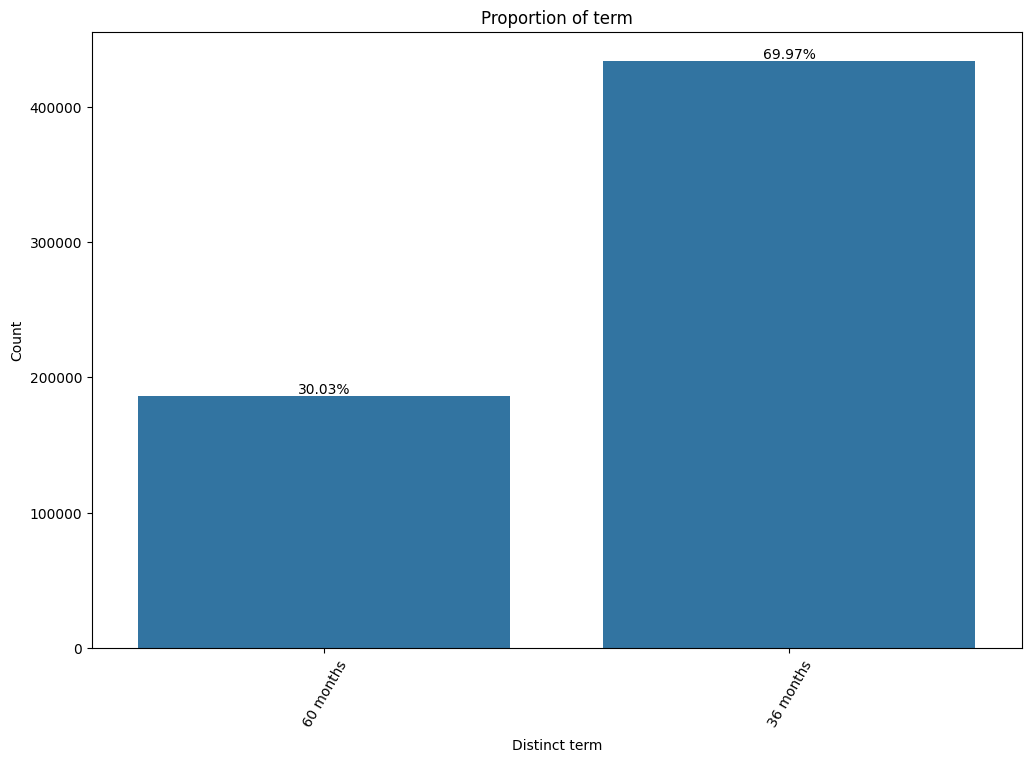



Column grade has 7 categories
  grade   count    pct
0     B  178339  28.76
1     C  171827  27.71
2     A  104223  16.81
3     D   97174  15.67
4     E   48871   7.88
5     F   15889   2.56
6     G    3677   0.59


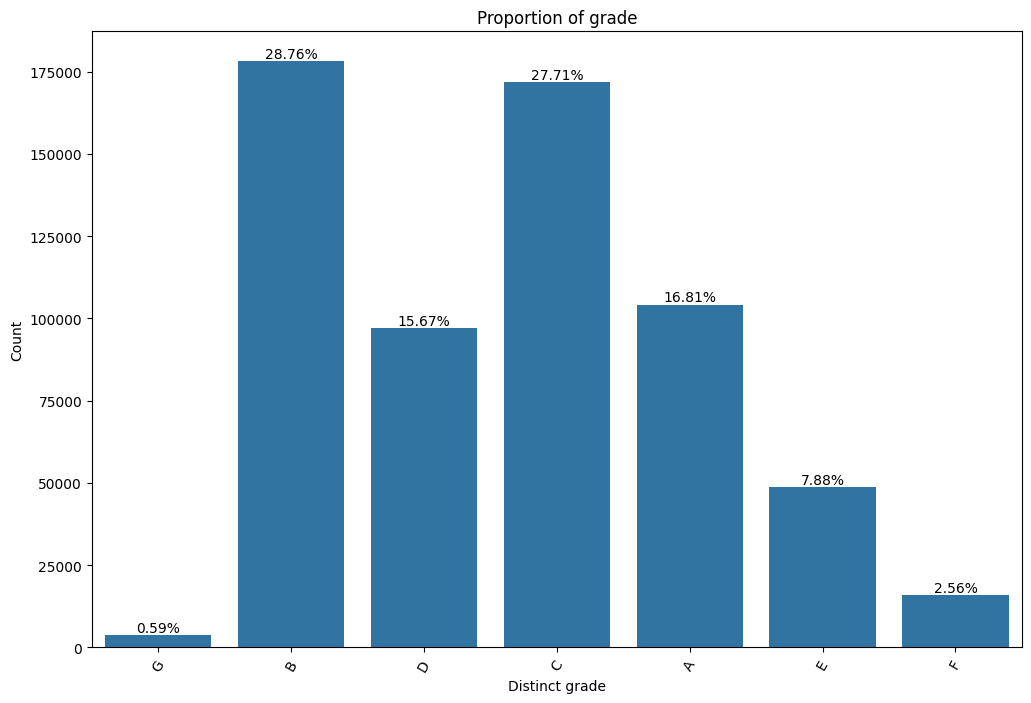



Column home_ownership has 5 categories
  home_ownership   count    pct
0       MORTGAGE  310062  50.01
1           RENT  248792  40.13
2            OWN   61013   9.84
3          OTHER     103   0.02
4           NONE      30   0.00


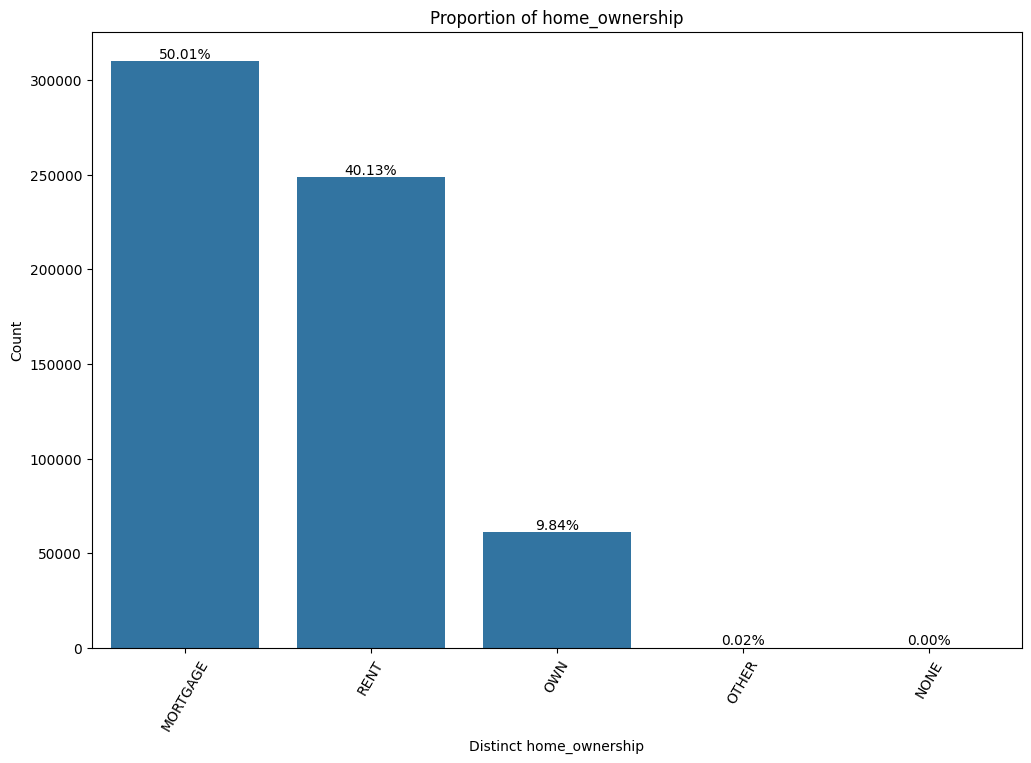



Column loan_status has 6 categories
          loan_status   count    pct
0             Current  428887  69.18
1          Fully Paid  148008  23.87
2         Charged Off   32187   5.19
3  Late (31-120 days)    8342   1.35
4   Late (16-30 days)    1709   0.28
5             Default     867   0.14


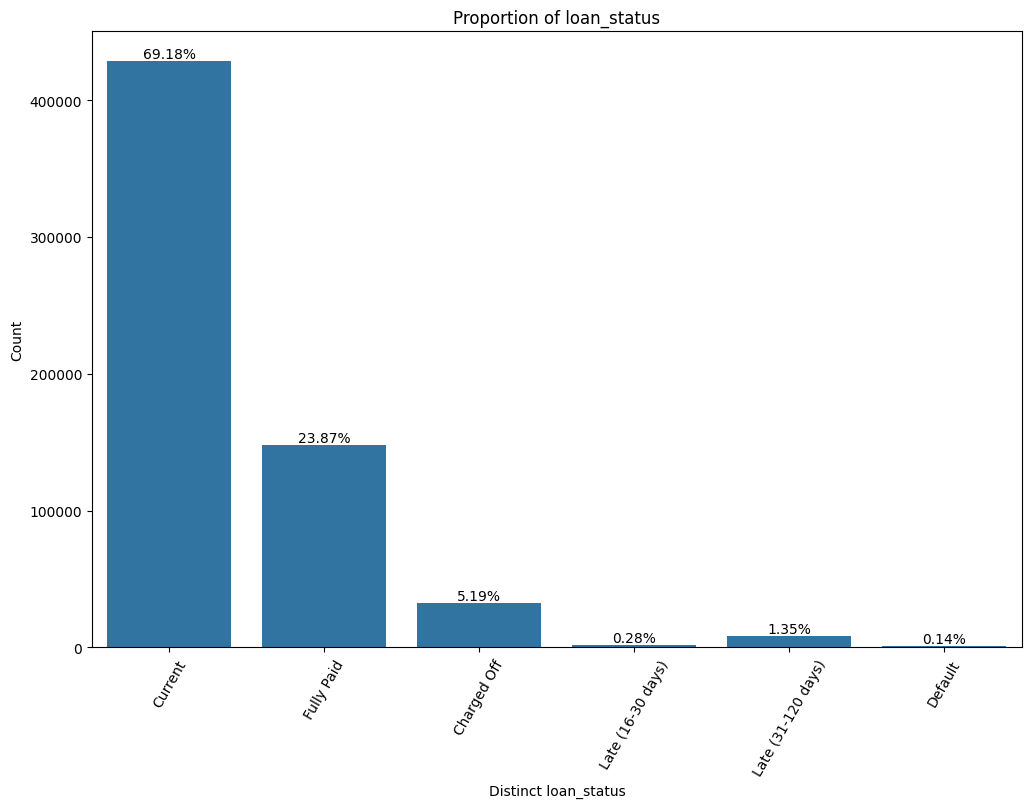



Column pymnt_plan has 2 categories
  pymnt_plan   count    pct
0          n  619991  100.0
1          y       9    0.0


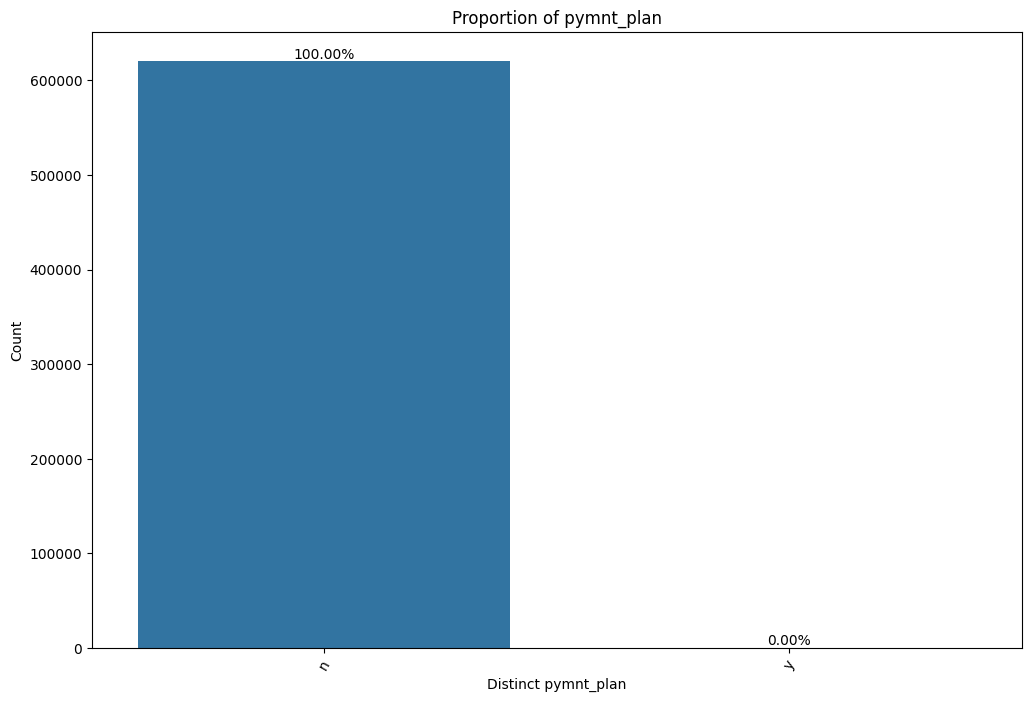



Column purpose has 14 categories
               purpose   count    pct
0   debt_consolidation  366266  59.08
1          credit_card  144694  23.34
2     home_improvement   36337   5.86
3                other   29634   4.78
4       major_purchase   11988   1.93
5       small_business    7134   1.15
6                  car    6132   0.99
7              medical    5969   0.96
8               moving    3759   0.61
9             vacation    3262   0.53
10               house    2559   0.41
11             wedding    1639   0.26
12    renewable_energy     396   0.06
13         educational     231   0.04


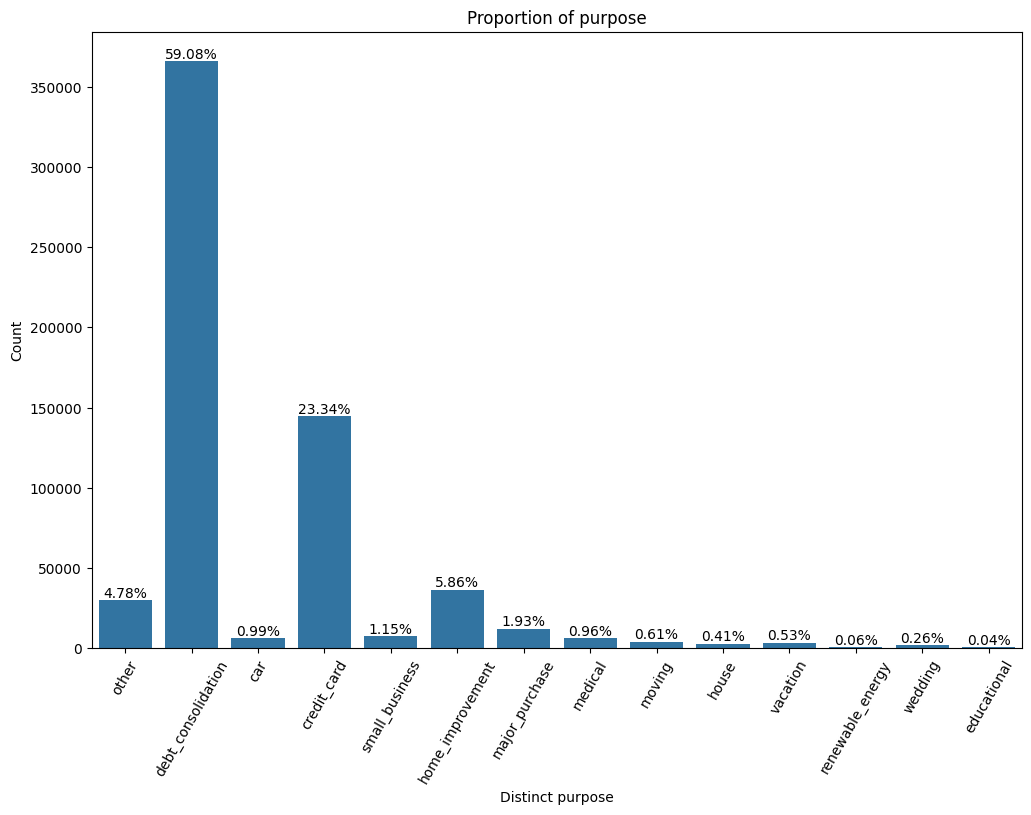



Column earliest_cr_line has 685 categories
    earliest_cr_line  count   pct
0              1-Aug   4678  0.75
1             Aug-00   4630  0.75
2             Oct-00   4371  0.70
3              2-Aug   4261  0.69
4              1-Oct   4248  0.69
..               ...    ...   ...
680           Feb-59      1  0.00
681           Mar-59      1  0.00
682           Dec-51      1  0.00
683           Dec-59      1  0.00
684           Oct-57      1  0.00

[685 rows x 3 columns]


Column earliest_cr_line_cleanedup has 685 categories
    earliest_cr_line_cleanedup  count   pct
0                     8/1/2001   4678  0.75
1                     8/1/2000   4630  0.75
2                    10/1/2000   4371  0.70
3                     8/1/2002   4261  0.69
4                    10/1/2001   4248  0.69
..                         ...    ...   ...
680                   2/1/1959      1  0.00
681                   3/1/1959      1  0.00
682                  12/1/1951      1  0.00
683                  12/1/19

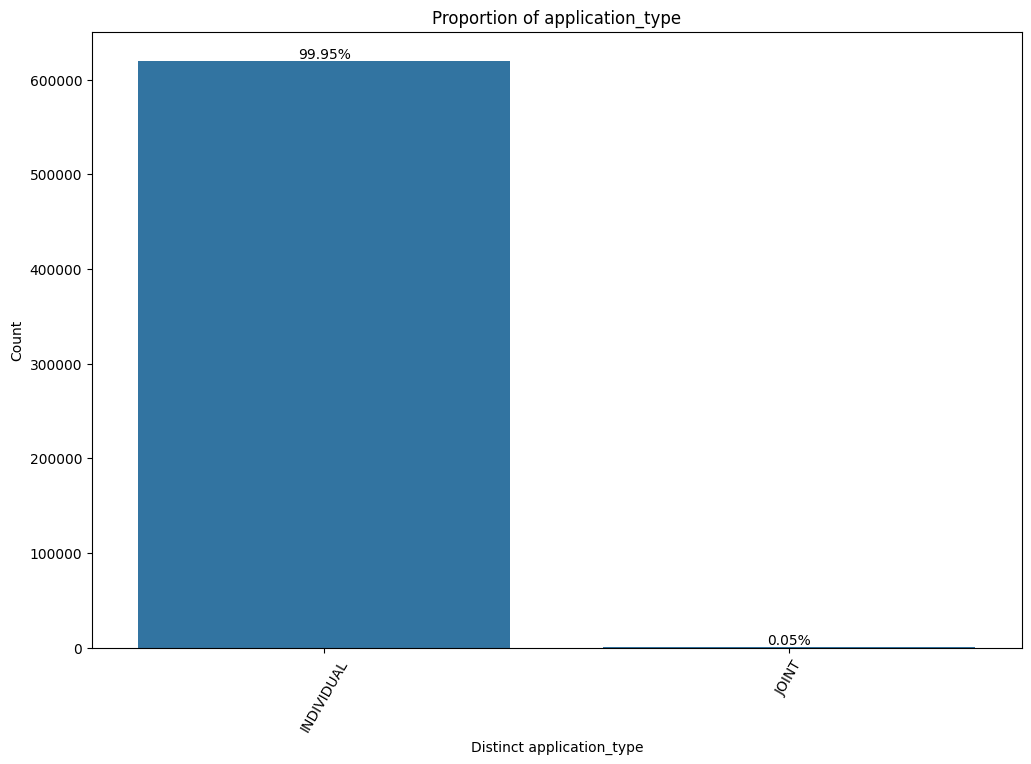

In [18]:
for cat_col in list(df.describe(include="object").T.index):
    print(f"Column {cat_col} has {len(get_cat_col_pct(df = df, col = cat_col))} categories")
    print(get_cat_col_pct(df = df, col = cat_col))
    if len(get_cat_col_pct(df = df, col = cat_col)) <= 15:
        show_viz(cat_col, df)
    print("\n")

In [19]:
df.describe(include="number").T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,620000.0,14770.102702,8434.178534,500.00,8000.00,13000.00,20000.00,35000.00
int_rate,620000.0,13.237590,4.380774,5.32,9.99,12.99,16.20,28.99
installment,620000.0,437.079064,244.140984,15.69,260.85,382.55,572.94,1445.46
emp_length,620000.0,6.013411,3.570636,0.00,3.00,6.00,10.00,10.00
annual_inc,620000.0,75056.828598,65461.333164,0.00,45000.00,65000.00,90000.00,9500000.00
dti,620000.0,18.140135,15.213483,0.00,11.90,17.64,23.93,9999.00
delinq_2yrs,620000.0,0.311750,0.856982,0.00,0.00,0.00,0.00,39.00
earliest_cr_line_elapseddays,620000.0,7463.042327,2715.694892,2108.00,5580.00,6918.00,8836.00,27250.00
inq_last_6mths,620000.0,0.682748,0.965801,0.00,0.00,0.00,1.00,8.00
mths_since_last_delinq,301752.0,34.133779,21.862729,0.00,15.00,31.00,50.00,171.00


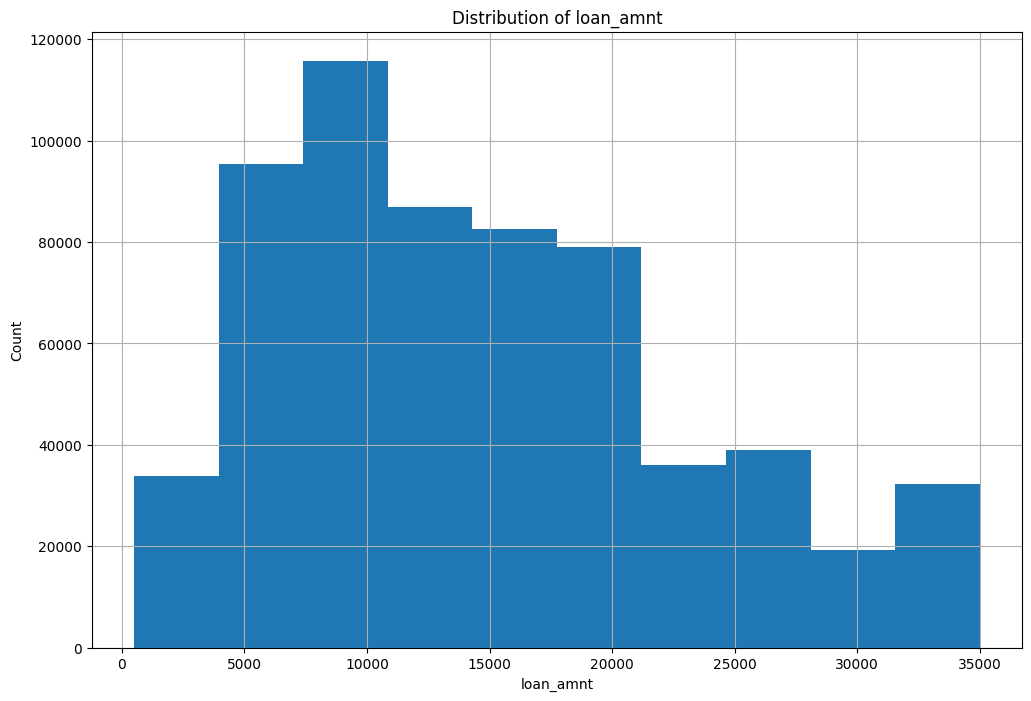

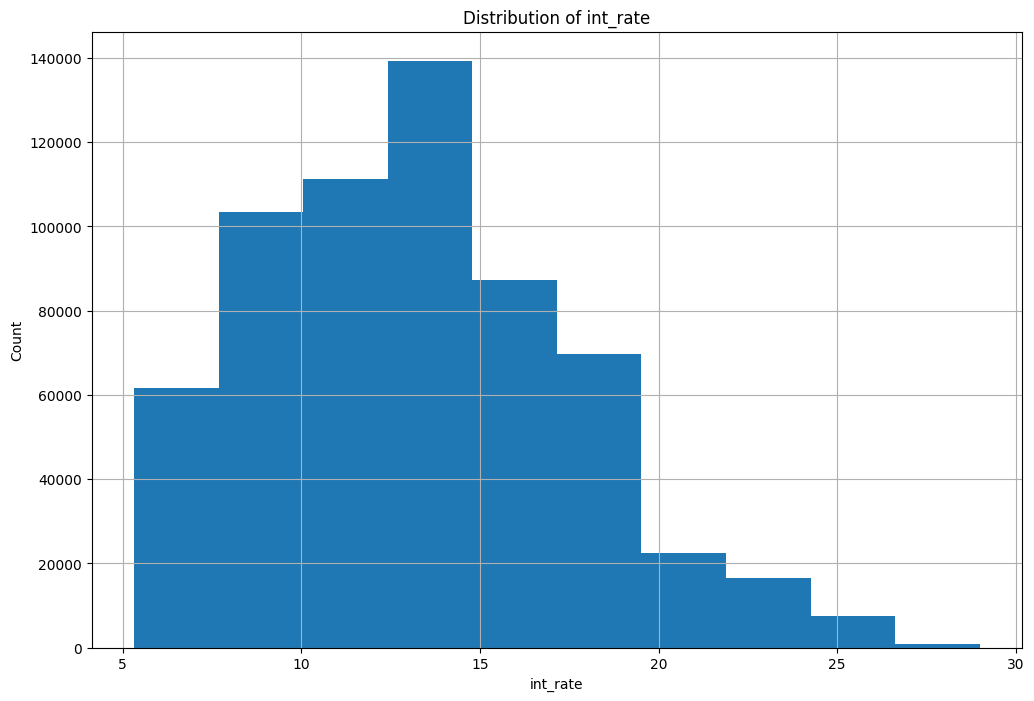

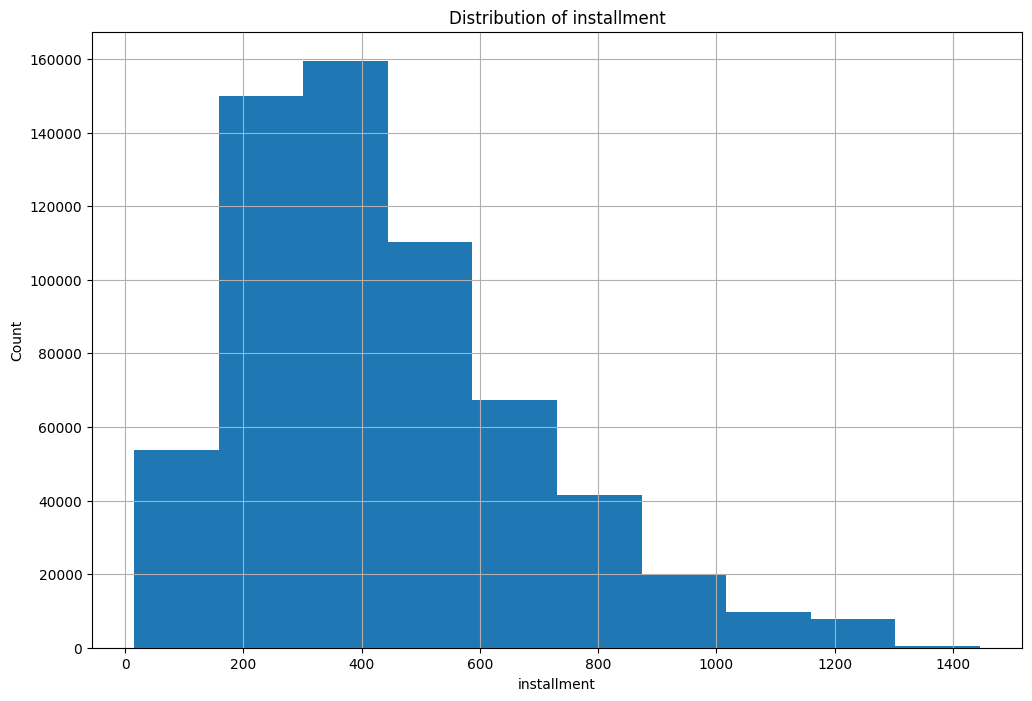

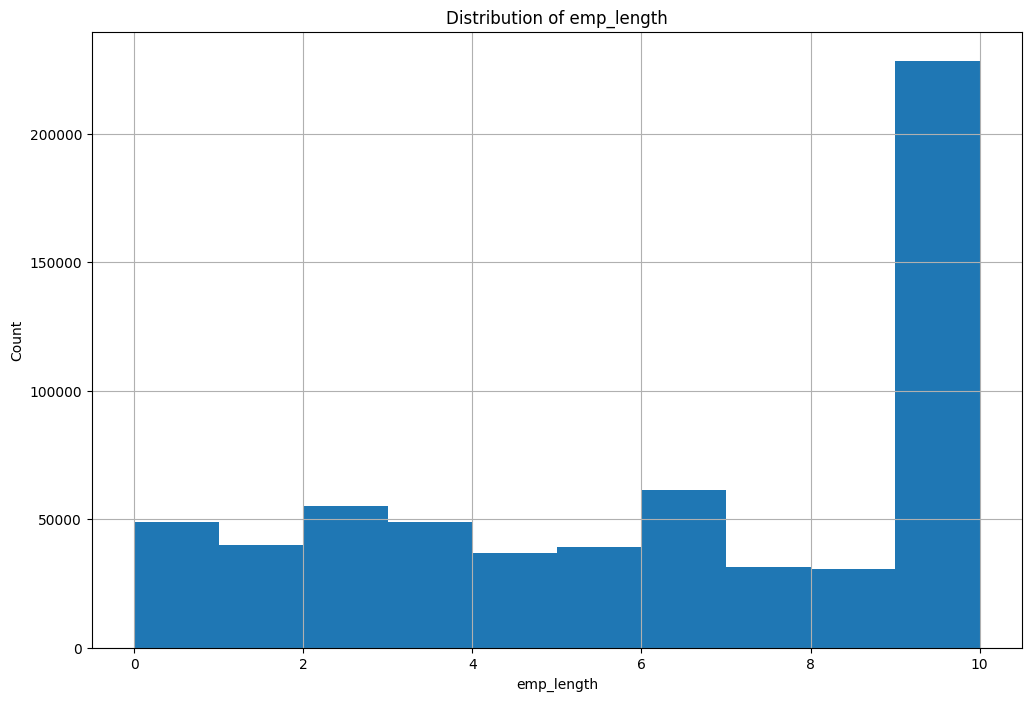

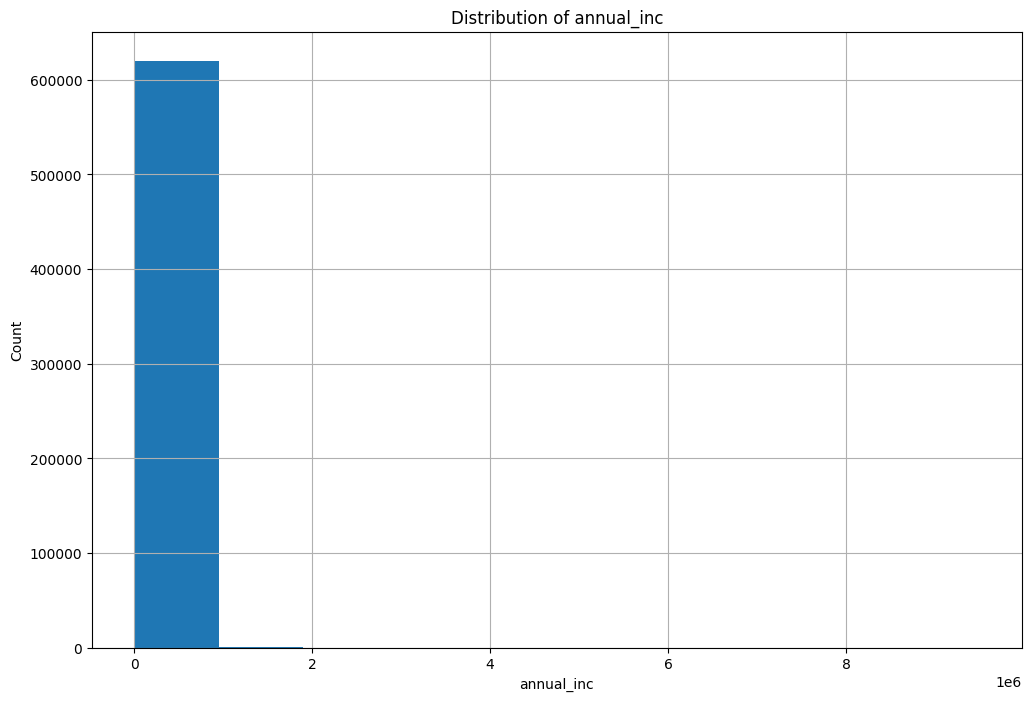

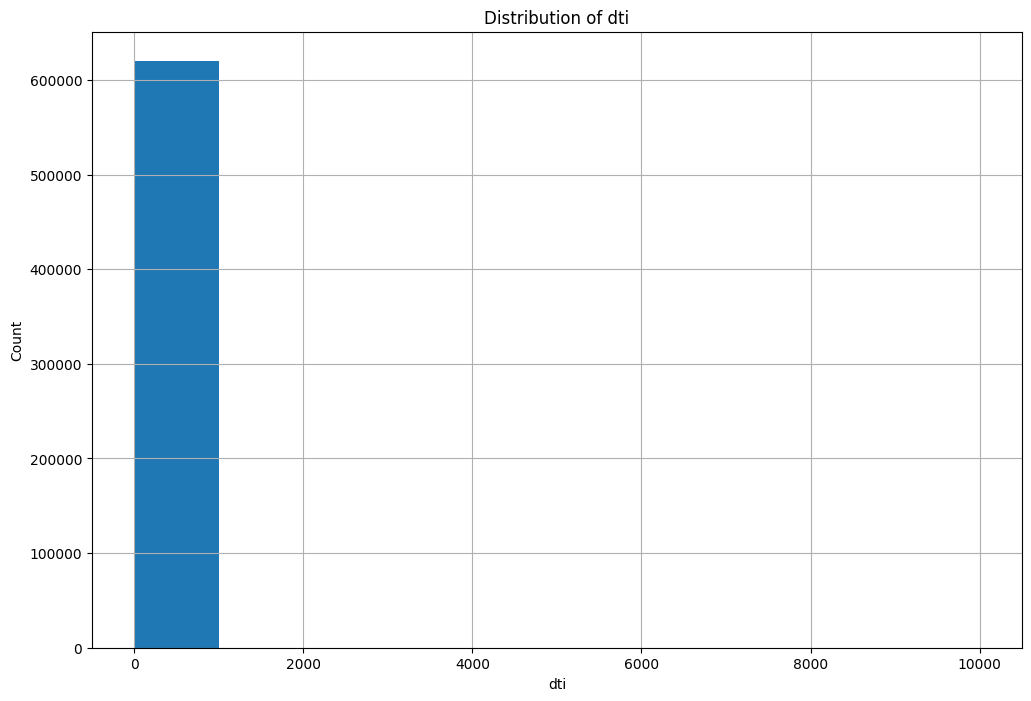

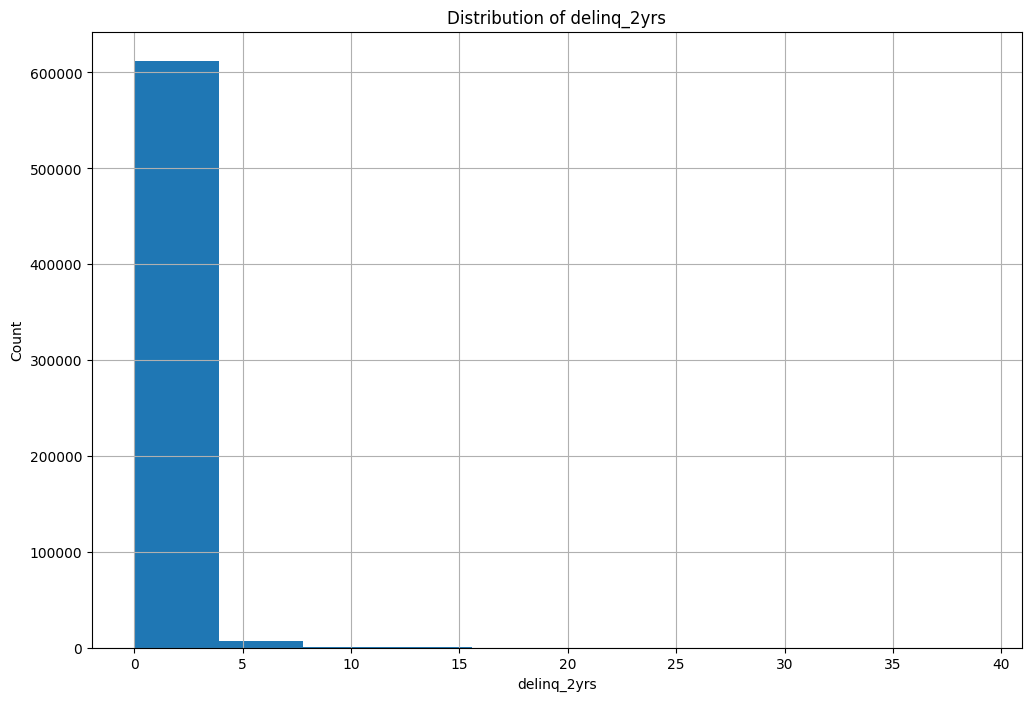

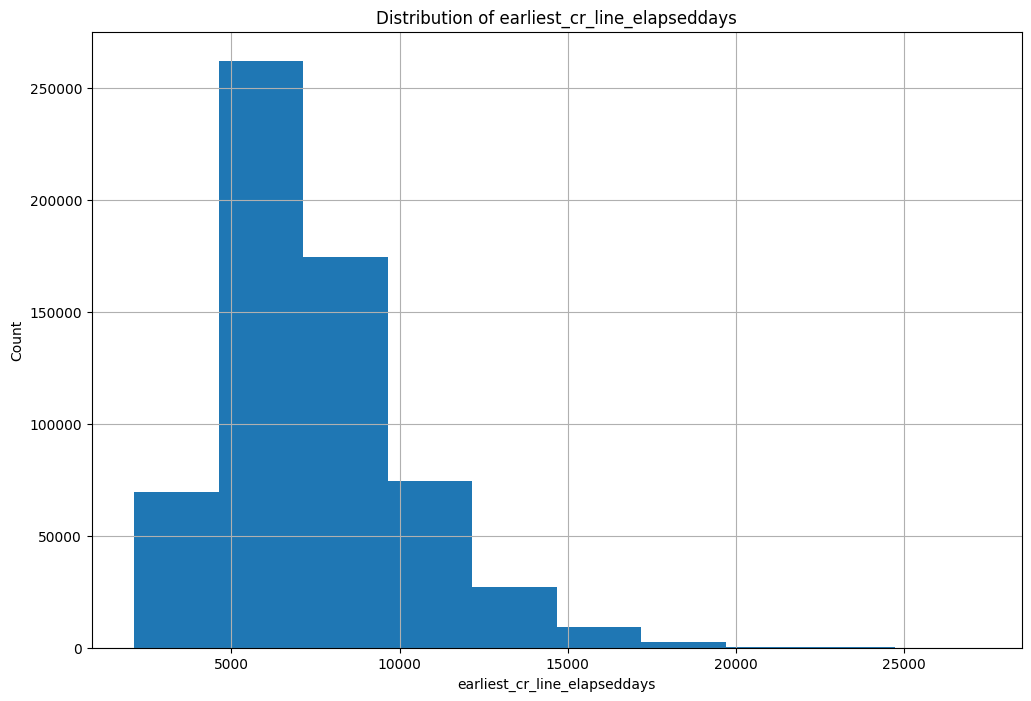

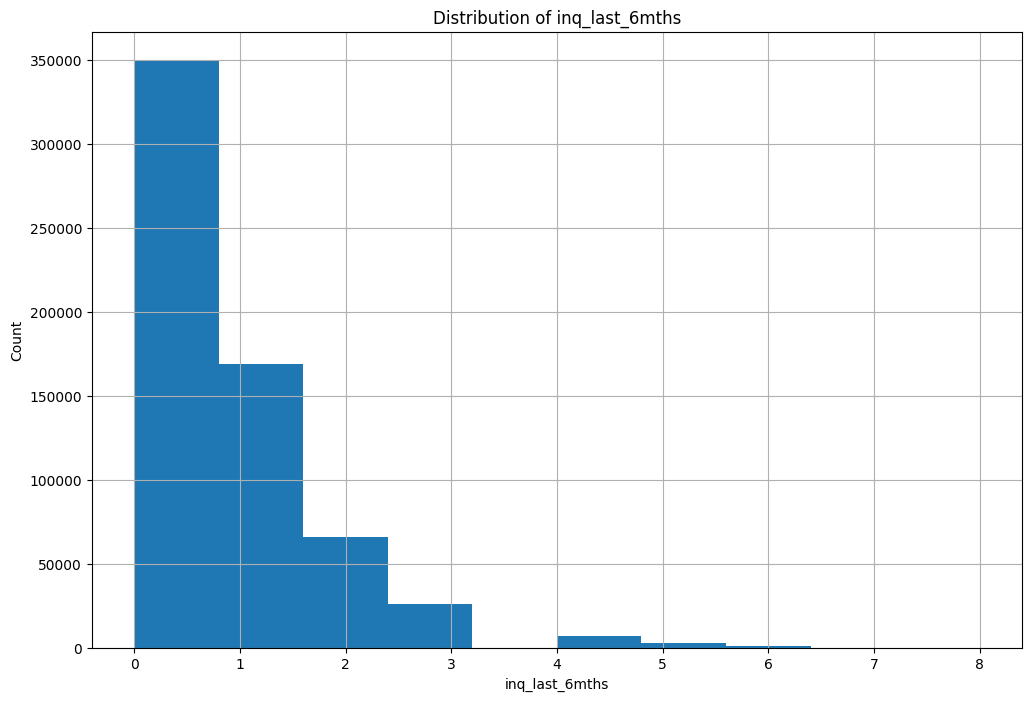

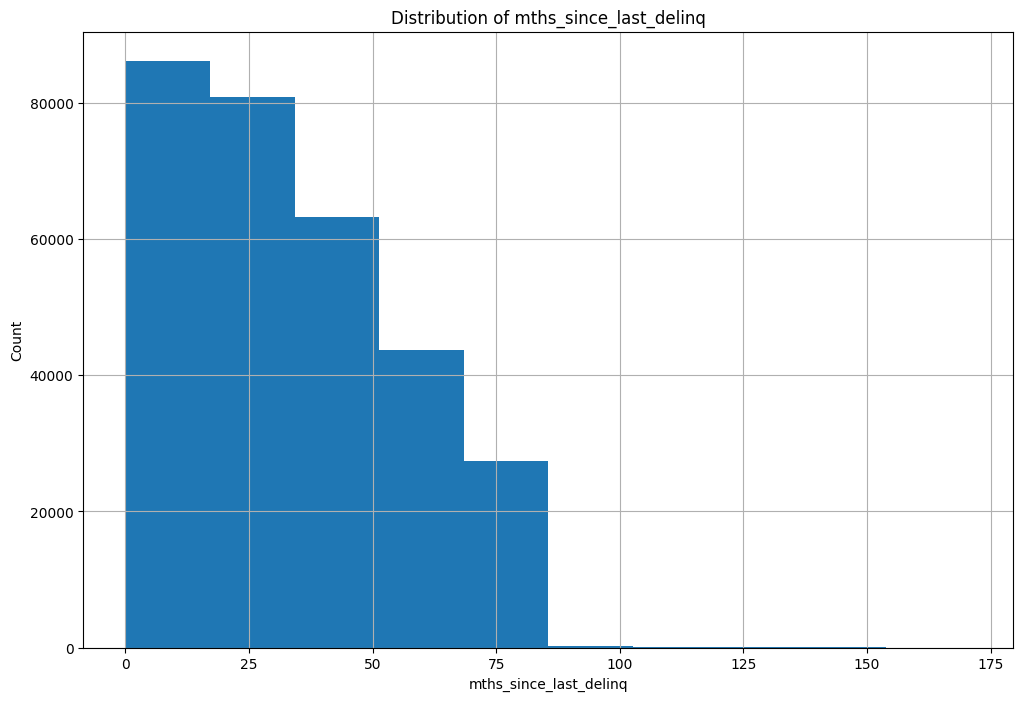

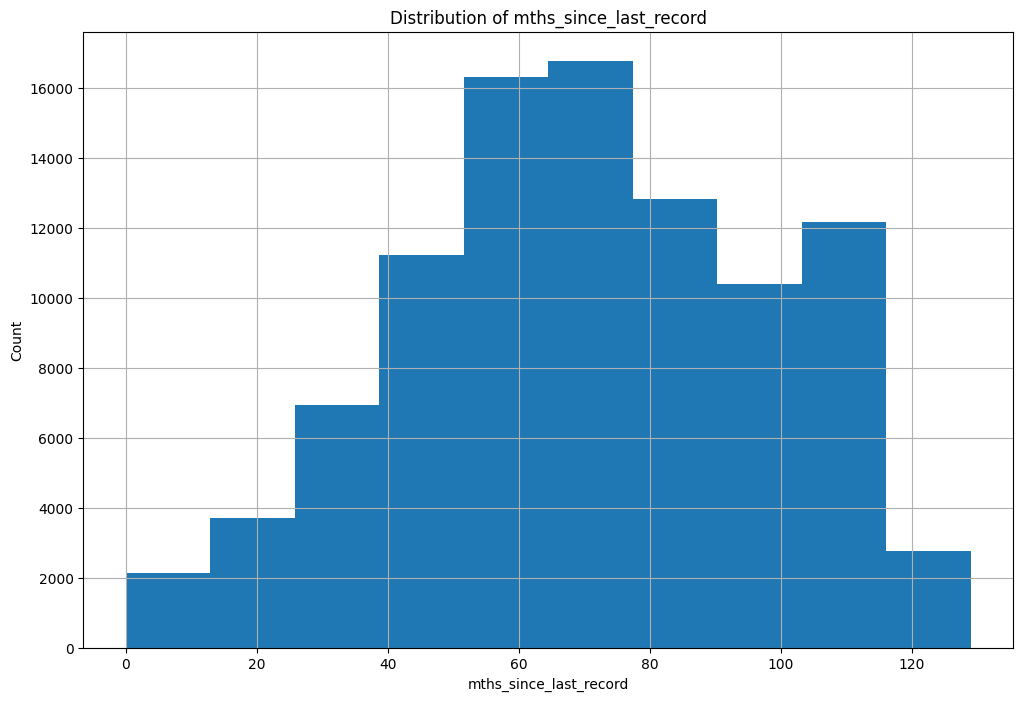

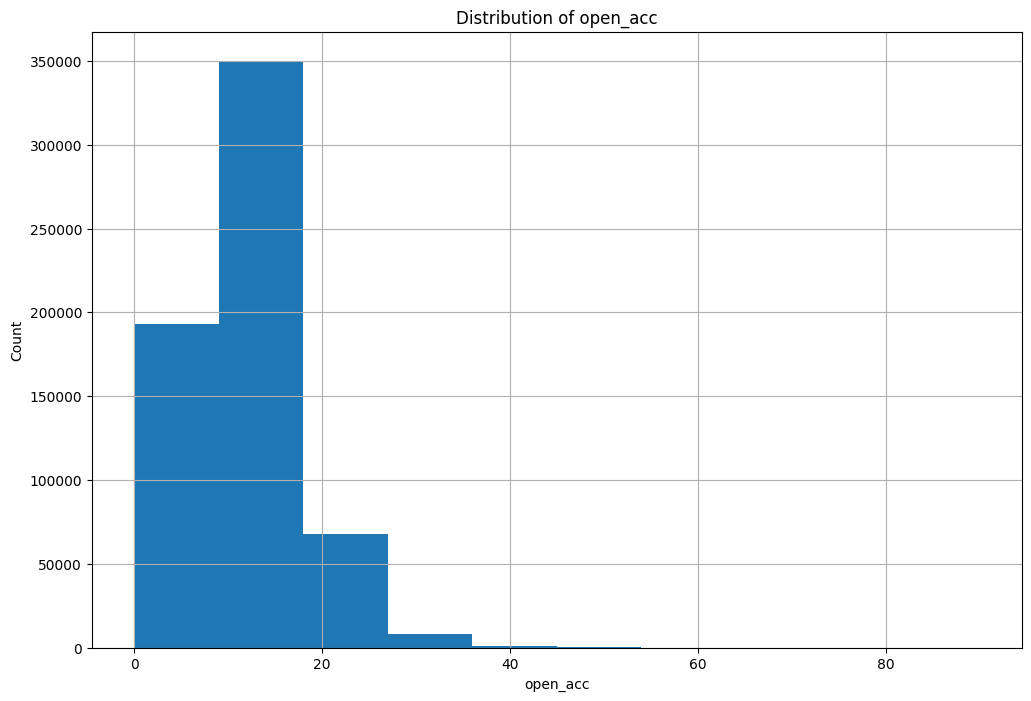

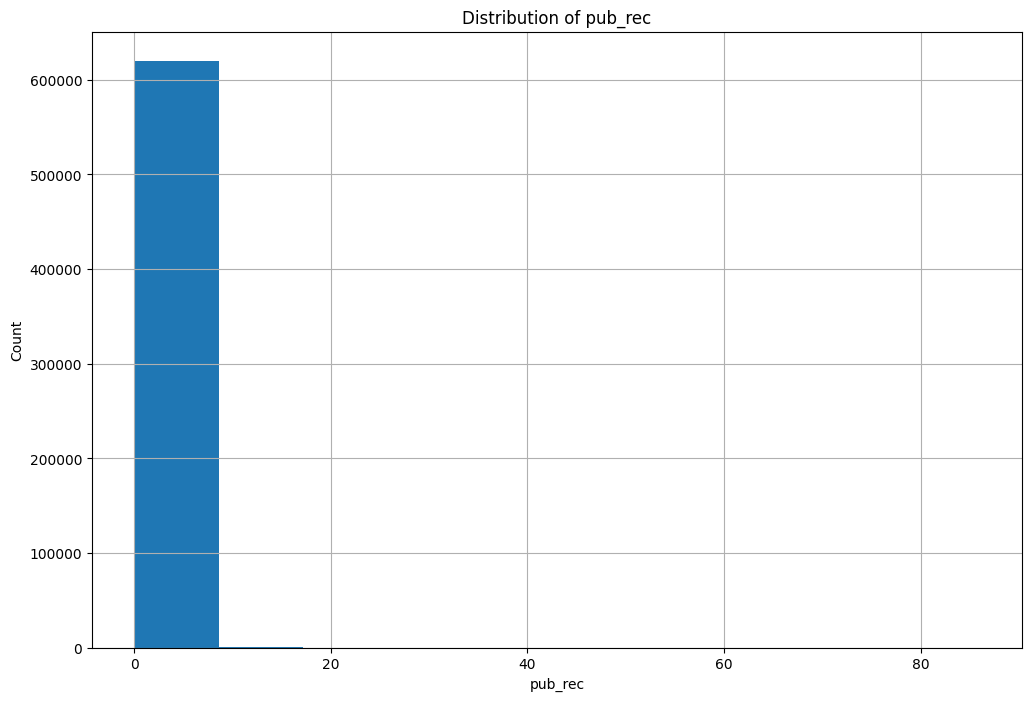

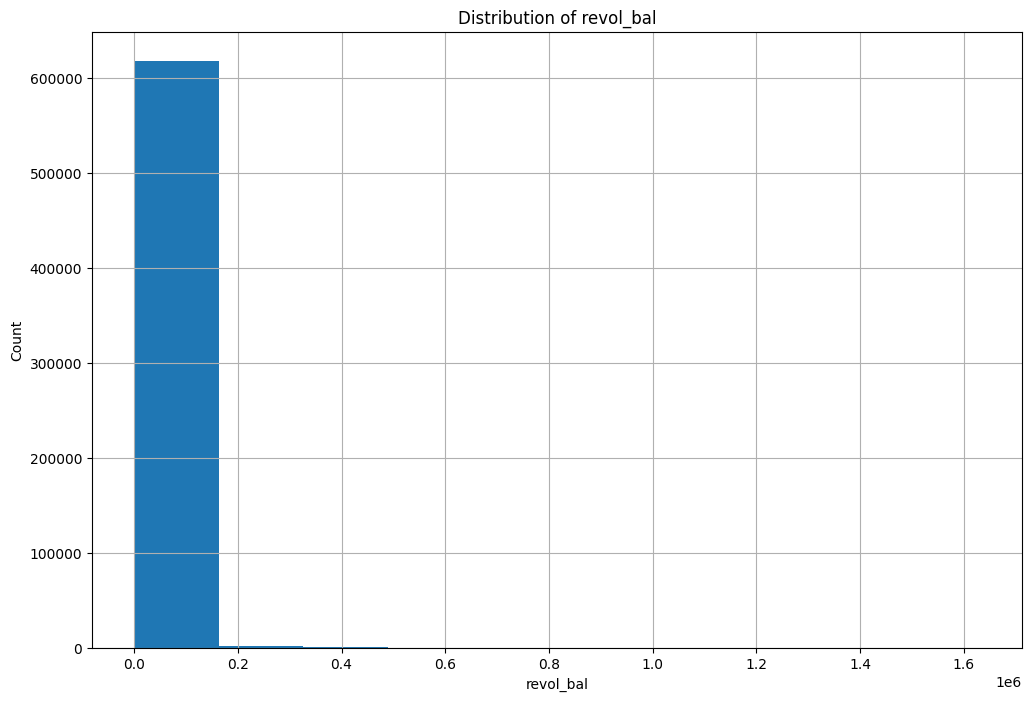

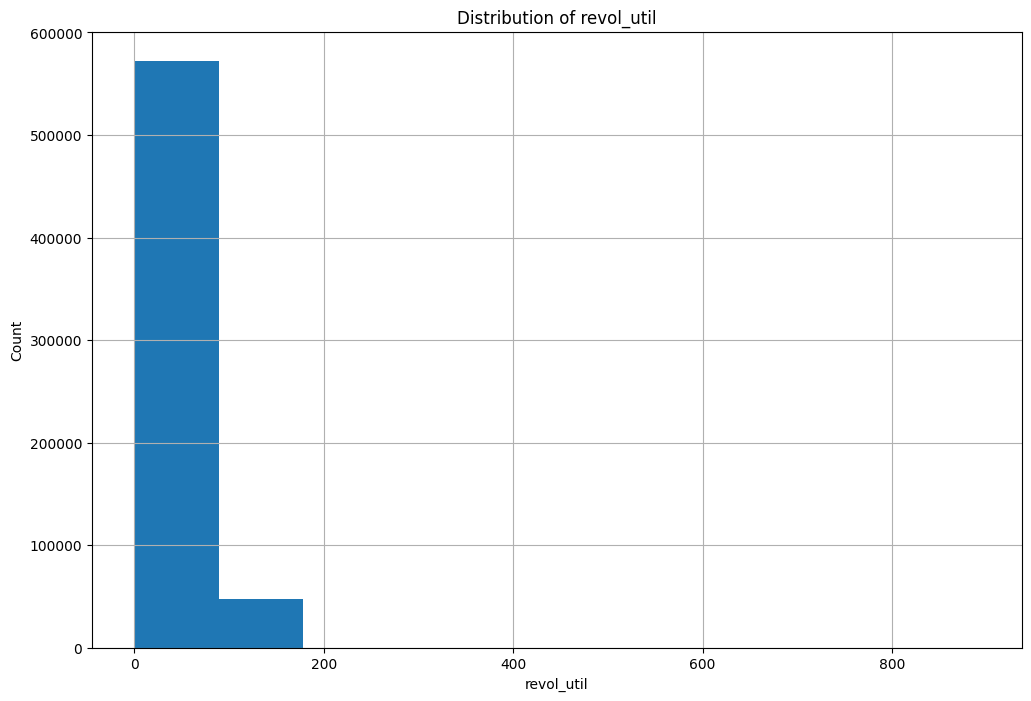

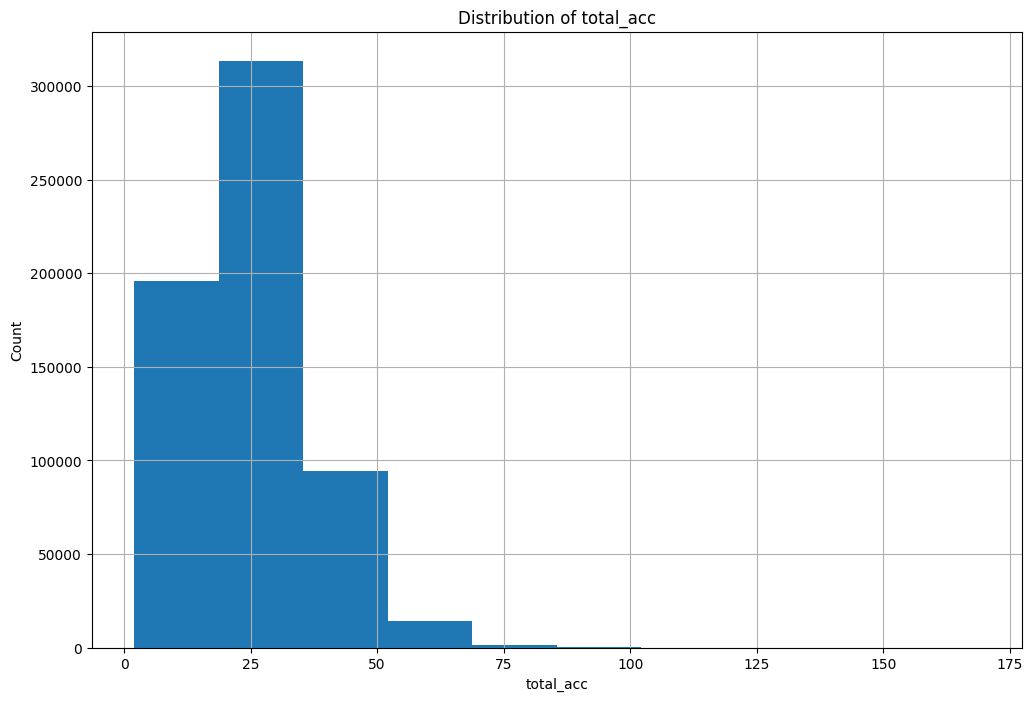

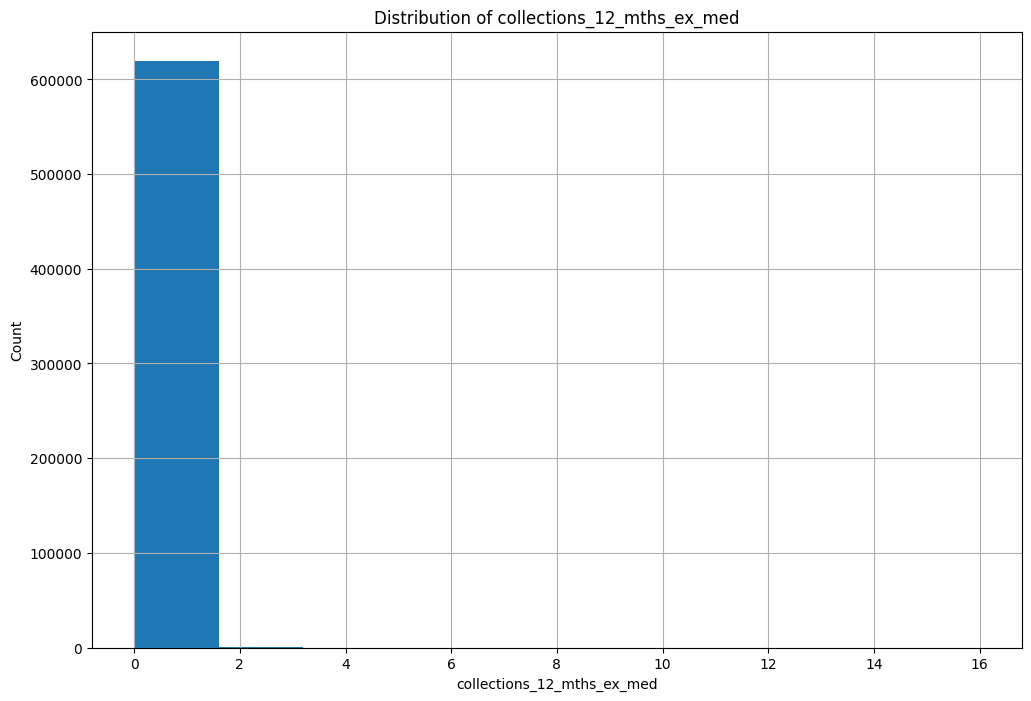

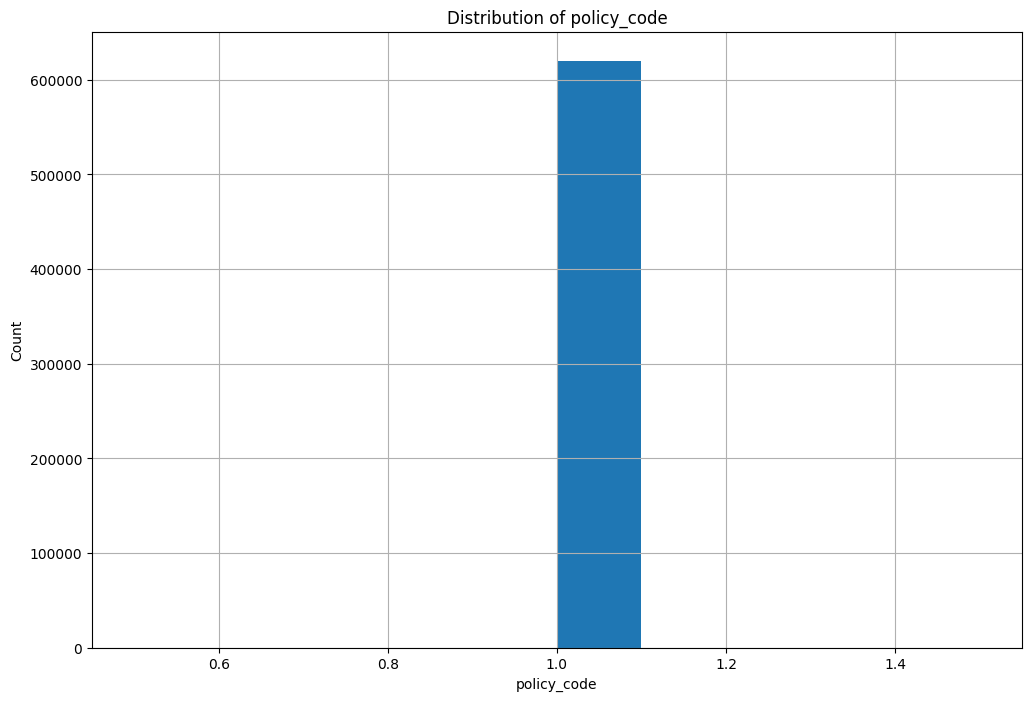

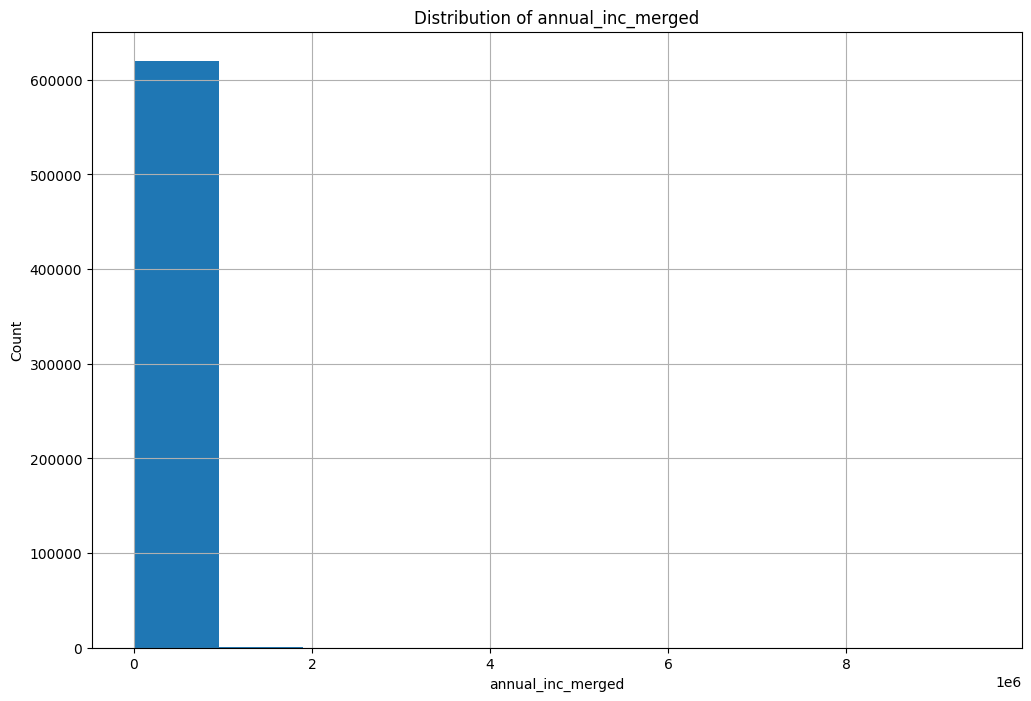

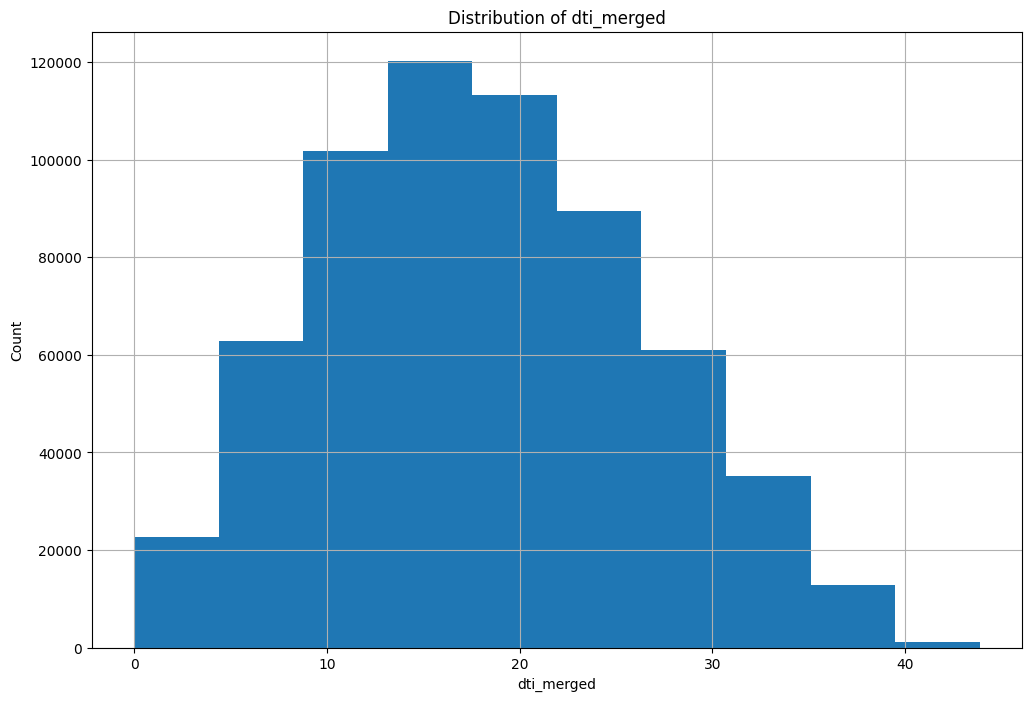

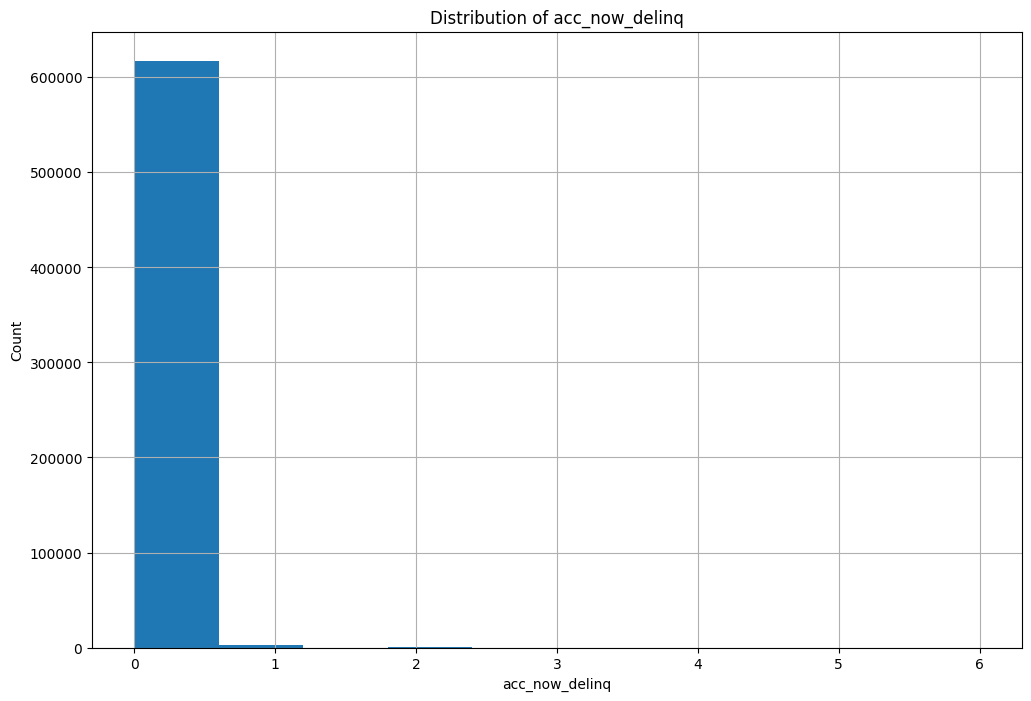

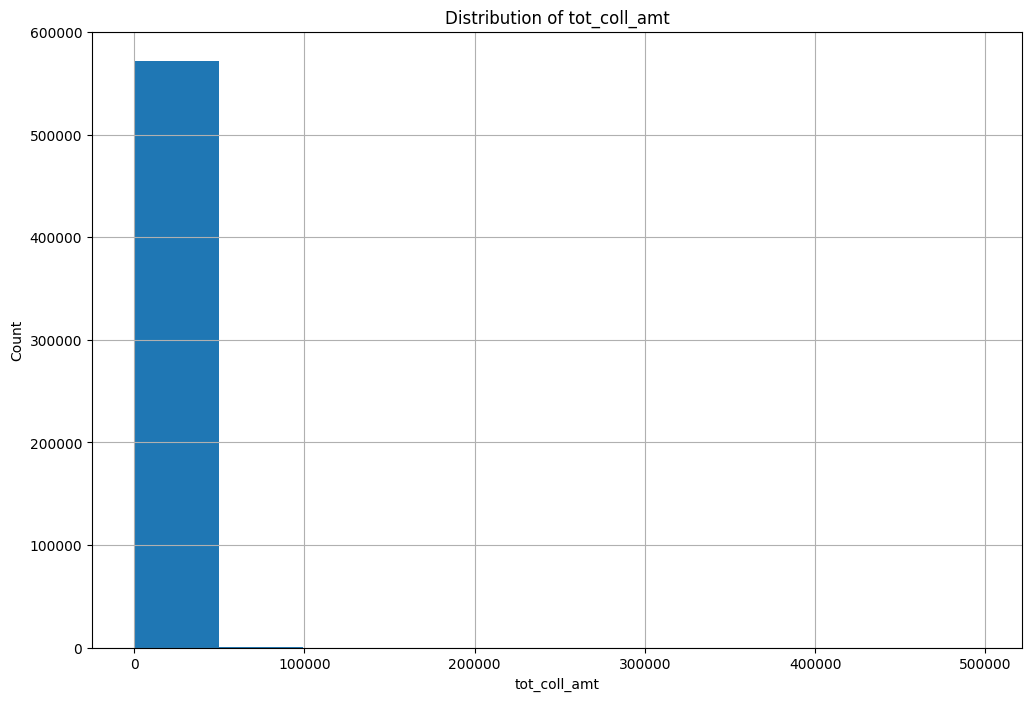

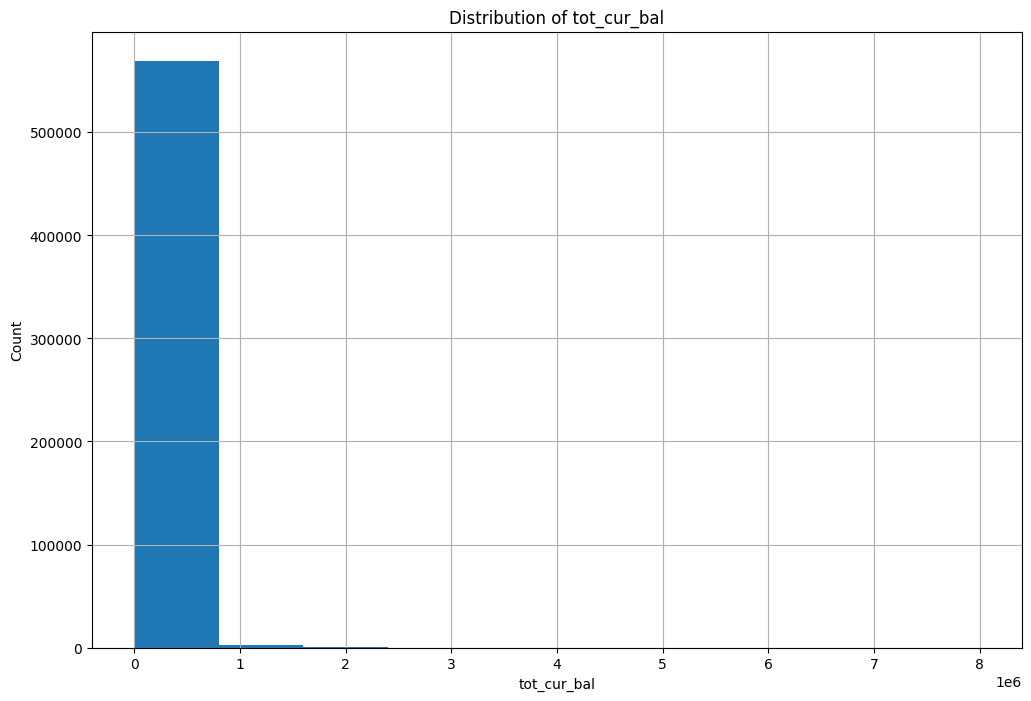

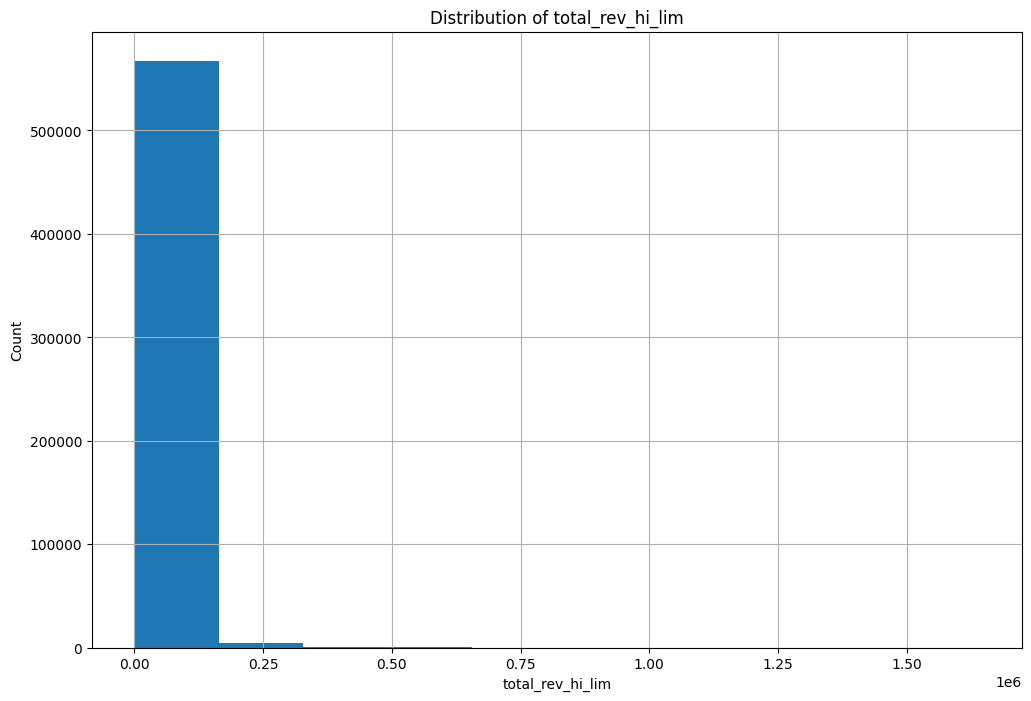

In [20]:
for num_col in list(df.describe(include="number").T.index):
    df[num_col].hist(figsize=(12, 8))
    plt.title(f'Distribution of {num_col}')
    plt.xlabel(f'{num_col}')
    plt.ylabel('Count')
    plt.show()

## **Checking mode**

In [21]:
df.mode(dropna=False)

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,loan_status,pymnt_plan,...,total_acc,collections_12_mths_ex_med,policy_code,application_type,annual_inc_merged,dti_merged,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,10000.0,36 months,10.99,327.34,B,10.0,MORTGAGE,60000.0,Current,n,...,22.0,0.0,1.0,INDIVIDUAL,60000.0,14.4,0.0,0.0,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN


## **Checking top few records**

In [22]:
df.head()

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,loan_status,pymnt_plan,...,total_acc,collections_12_mths_ex_med,policy_code,application_type,annual_inc_merged,dti_merged,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,32075,60 months,27.31,985.38,G,10,MORTGAGE,89100.0,Current,n,...,19,0.0,1,INDIVIDUAL,89100.0,19.81,0,0.0,66305.0,4400.0
1,12000,36 months,9.99,387.15,B,0,RENT,50000.0,Current,n,...,11,0.0,1,INDIVIDUAL,50000.0,23.24,0,0.0,30438.0,24300.0
2,8000,36 months,13.11,269.98,B,6,MORTGAGE,85000.0,Fully Paid,n,...,15,0.0,1,INDIVIDUAL,85000.0,11.76,0,0.0,38935.0,20500.0
3,10000,60 months,15.61,241.12,D,6,RENT,31000.0,Fully Paid,n,...,24,0.0,1,INDIVIDUAL,31000.0,21.19,0,784.0,26398.0,20600.0
4,5725,36 months,13.11,193.21,B,10,RENT,52000.0,Current,n,...,18,0.0,1,INDIVIDUAL,52000.0,16.21,0,0.0,25712.0,11500.0


## **Checking bottom few records**

In [23]:
df.tail()

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,loan_status,pymnt_plan,...,total_acc,collections_12_mths_ex_med,policy_code,application_type,annual_inc_merged,dti_merged,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
619995,32500,60 months,20.99,879.06,E,2,RENT,65000.0,Current,n,...,13,0.0,1,INDIVIDUAL,65000.0,2.16,0,0.0,9912.0,56800.0
619996,15000,60 months,13.99,348.95,C,10,MORTGAGE,40000.0,Current,n,...,19,0.0,1,INDIVIDUAL,40000.0,21.24,0,0.0,139557.0,20600.0
619997,20000,36 months,10.64,651.37,B,1,MORTGAGE,85000.0,Current,n,...,34,0.0,1,INDIVIDUAL,85000.0,24.50,0,280.0,267451.0,35000.0
619998,17000,60 months,13.33,389.69,C,6,MORTGAGE,112000.0,Current,n,...,17,0.0,1,INDIVIDUAL,112000.0,15.73,0,0.0,475617.0,22700.0
619999,24000,36 months,12.69,805.08,C,2,OWN,60000.0,Current,n,...,22,1.0,1,INDIVIDUAL,60000.0,9.98,0,370.0,219643.0,16400.0


## **Data profiling**

In [24]:
'''
# Data profiling
profile = ProfileReport(df,
                        title="Loan Data EDA",
                        explorative=True,
                       )
profile
'''

'\n# Data profiling\nprofile = ProfileReport(df,\n                        title="Loan Data EDA",\n                        explorative=True,\n                       )\nprofile\n'

In [25]:
'''
annual_inc is highly overall correlated with annual_inc_merged and 2 other fields	High correlation
annual_inc_merged is highly overall correlated with annual_inc and 2 other fields	High correlation
dti is highly overall correlated with dti_merged	High correlation
dti_merged is highly overall correlated with dti	High correlation
installment is highly overall correlated with loan_amnt	High correlation
loan_amnt is highly overall correlated with annual_inc and 3 other fields	High correlation
loan_status is highly overall correlated with loan_status_code	High correlation
loan_status_code is highly overall correlated with loan_status	High correlation
mths_since_last_record is highly overall correlated with pub_rec	High correlation
open_acc is highly overall correlated with total_acc and 1 other fields	High correlation
pub_rec is highly overall correlated with mths_since_last_record	High correlation
revol_bal is highly overall correlated with loan_amnt and 1 other fields	High correlation
tot_cur_bal is highly overall correlated with annual_inc and 1 other fields	High correlation
total_acc is highly overall correlated with open_acc	High correlation
total_rev_hi_lim is highly overall correlated with open_acc and 1 other fields	High correlation
'''

'\nannual_inc is highly overall correlated with annual_inc_merged and 2 other fields\tHigh correlation\nannual_inc_merged is highly overall correlated with annual_inc and 2 other fields\tHigh correlation\ndti is highly overall correlated with dti_merged\tHigh correlation\ndti_merged is highly overall correlated with dti\tHigh correlation\ninstallment is highly overall correlated with loan_amnt\tHigh correlation\nloan_amnt is highly overall correlated with annual_inc and 3 other fields\tHigh correlation\nloan_status is highly overall correlated with loan_status_code\tHigh correlation\nloan_status_code is highly overall correlated with loan_status\tHigh correlation\nmths_since_last_record is highly overall correlated with pub_rec\tHigh correlation\nopen_acc is highly overall correlated with total_acc and 1 other fields\tHigh correlation\npub_rec is highly overall correlated with mths_since_last_record\tHigh correlation\nrevol_bal is highly overall correlated with loan_amnt and 1 other fi

In [26]:
df.drop(['policy_code',
         'earliest_cr_line',
         'earliest_cr_line_cleanedup',
         'earliest_cr_line_elapseddays',
         'collections_12_mths_ex_med',
         'acc_now_delinq',
         'grade',
         'annual_inc_merged',
         'dti_merged',
         'tot_coll_amt',
         'tot_cur_bal',
         'total_rev_hi_lim',
         'dti',
         'mths_since_last_record',
         'open_acc',
         'pub_rec',
         'revol_bal',
         'total_acc',
         'earliest_cr_line',
         'earliest_cr_line_cleanedup',
         'earliest_cr_line_elapseddays'
         ],
        axis=1, inplace=True)

As fully paid loans are already paid, for the analysis, we are dropping them off.

In [27]:
df = df[df["loan_status"] != "Fully Paid"]
df.shape

(471992, 15)

In [28]:
get_cat_col_pct(df = df, col = 'loan_status')

,loan_status,count,pct
0,Current,428887,90.87
1,Charged Off,32187,6.82
2,Late (31-120 days),8342,1.77
3,Late (16-30 days),1709,0.36
4,Default,867,0.18


As the late loans (in two buckets) are in the delinquent bucket, we are considering them in the default bucket as an indication of being defaulted soon.

In [29]:
df.loc[df["loan_status"] == "Late (31-120 days)", "loan_status"] = "Default"
df.loc[df["loan_status"] == "Late (16-30 days)", "loan_status"] = "Default"
get_cat_col_pct(df = df, col = 'loan_status')

,loan_status,count,pct
0,Current,428887,90.87
1,Charged Off,32187,6.82
2,Default,10918,2.31


Loans go into default after missing multiple payments. A charge off occurs when the account goes unpaid for 120 to 180 days. We have already bucketed late payments in the default category as an early signal of being default. We are also clubbing the charged off loans in the default category as then event has already happened.

In [30]:
df.loc[df["loan_status"] == "Charged Off", "loan_status"] = "Default"
get_cat_col_pct(df = df, col = 'loan_status')

,loan_status,count,pct
0,Current,428887,90.87
1,Default,43105,9.13


Current loans may turn into a bad loan in the subsequent terms and thus can be defaulted.

Based on the data, it looks like that with payment plan, there is a high proportion of defaulting. Also, wedding, moving, renewable energy purposed loans show higher proportion of defaulting.

In [31]:
for cat_col in list(df.describe(include="object").T.index):
    if cat_col != "loan_status":
        print(f"Processing column {cat_col}")
        print(get_stats_for_target(df = df, col = cat_col, tgt_col="loan_status"))
        print("\n")

Processing column term
                        proportion
term       loan_status            
 36 months Current        0.912993
           Default        0.087007
 60 months Current        0.900058
           Default        0.099942


Processing column home_ownership
                            proportion
home_ownership loan_status            
MORTGAGE       Current        0.919892
               Default        0.080108
NONE           Default        0.800000
               Current        0.200000
OTHER          Default        0.916667
               Current        0.083333
OWN            Current        0.917898
               Default        0.082102
RENT           Current        0.892439
               Default        0.107561


Processing column pymnt_plan
                        proportion
pymnt_plan loan_status            
n          Current        0.908681
           Default        0.091319
y          Default        0.571429
           Current        0.428571


Processing column pur

## **Missing values check and imputing**

In [32]:
for col in df.columns:
    if df[col].isnull().values.sum() > 0:
        print(f"Missing values present for {col}")
        print(df[col].isnull().sum())
        df[col] = df[col].fillna(df[col].mode()[0])
        print("\n")

Missing values present for mths_since_last_delinq
235799


Missing values present for revol_util
205




## **Label Encoding**

In [33]:
df['loan_status_code'] = df['loan_status'].map({'Current': 0, 'Default': 1})

In [34]:
df['pymnt_plan'] = df['pymnt_plan'].map({'n': 0, 'y': 1})

In [35]:
df['application_type'] = df['application_type'].map({'INDIVIDUAL': 0, 'JOINT': 1})

In [36]:
term_mapping = {label: idx for idx, label in enumerate(np.unique(df.term))}
term_mapping
df['term'] = df.term.map(term_mapping)

In [37]:
df.drop(['loan_status'],axis=1, inplace=True)

In [38]:
df.head()

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,pymnt_plan,purpose,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,revol_util,application_type,loan_status_code
0,32075,1,27.31,985.38,10,MORTGAGE,89100.0,0,other,0,1,57.0,13.7,0,0
1,12000,0,9.99,387.15,0,RENT,50000.0,0,debt_consolidation,0,0,9.0,49.7,0,0
4,5725,0,13.11,193.21,10,RENT,52000.0,0,car,0,0,9.0,70.9,0,0
6,19075,1,12.39,428.09,7,RENT,90000.0,0,debt_consolidation,0,0,9.0,61.0,0,0
7,18000,0,6.92,555.13,2,RENT,106500.0,0,debt_consolidation,0,0,9.0,18.1,0,0


In [39]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'emp_length',
       'home_ownership', 'annual_inc', 'pymnt_plan', 'purpose', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq', 'revol_util',
       'application_type', 'loan_status_code'],
      dtype='object')

In [40]:
get_stats_for_target(df = df, col = 'application_type', tgt_col="loan_status_code").reset_index()

,application_type,loan_status_code,proportion
0,0,0,0.908614
1,0,1,0.091386
2,1,0,0.996904
3,1,1,0.003096


Other than mortgage purpose, other loans have higher chance to being default.

In [41]:
get_stats_for_target(df = df, col = 'home_ownership', tgt_col="loan_status_code").reset_index()

,home_ownership,loan_status_code,proportion
0,MORTGAGE,0,0.919892
1,MORTGAGE,1,0.080108
2,NONE,1,0.800000
3,NONE,0,0.200000
4,OTHER,1,0.916667
5,OTHER,0,0.083333
6,OWN,0,0.917898
7,OWN,1,0.082102
8,RENT,0,0.892439
9,RENT,1,0.107561


Educational purpose loans are prone to default than any other categories.

In [42]:
get_stats_for_target(df = df, col = 'purpose', tgt_col="loan_status_code").reset_index()

,purpose,loan_status_code,proportion
0,car,0,0.899586
1,car,1,0.100414
2,credit_card,0,0.934338
3,credit_card,1,0.065662
4,debt_consolidation,0,0.904994
5,debt_consolidation,1,0.095006
6,educational,1,0.973684
7,educational,0,0.026316
8,home_improvement,0,0.918440
9,home_improvement,1,0.081560


## **Fature engineering**

Based on purpose and home ownership, we are creating two binary columns.

In [43]:
df['education_purpose_loan_flag'] = df['purpose'].map({'educational': 1})
df['education_purpose_loan_flag'] = df['education_purpose_loan_flag'].fillna(0)
df['education_purpose_loan_flag'].drop_duplicates()
df.drop(['purpose'],axis=1, inplace=True)

In [44]:
df['mortgage_or_not_flag'] = df['home_ownership'].map({'MORTGAGE': 1})
df['mortgage_or_not_flag'] = df['mortgage_or_not_flag'].fillna(0)
df['mortgage_or_not_flag'].drop_duplicates()
df.drop(['home_ownership'],axis=1, inplace=True)

## **Working dataset creation**

In [45]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'emp_length',
       'annual_inc', 'pymnt_plan', 'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_delinq', 'revol_util', 'application_type',
       'loan_status_code', 'education_purpose_loan_flag',
       'mortgage_or_not_flag'],
      dtype='object')

In [46]:
work_df = copy.deepcopy(df[['loan_amnt', 'term', 'int_rate', 'installment', 'emp_length',
       'mortgage_or_not_flag', 'annual_inc', 'pymnt_plan', 'education_purpose_loan_flag',
       'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'revol_util',
       'application_type', 'loan_status_code']])

In [47]:
# Converting categorical column to dummy column
work_df = pd.get_dummies(work_df, dtype='int')
work_df.columns = [col.lower().replace(" ","_") for col in work_df.columns]
work_df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'emp_length',
       'mortgage_or_not_flag', 'annual_inc', 'pymnt_plan',
       'education_purpose_loan_flag', 'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_delinq', 'revol_util', 'application_type',
       'loan_status_code'],
      dtype='object')

## **Corelation**

<Axes: >

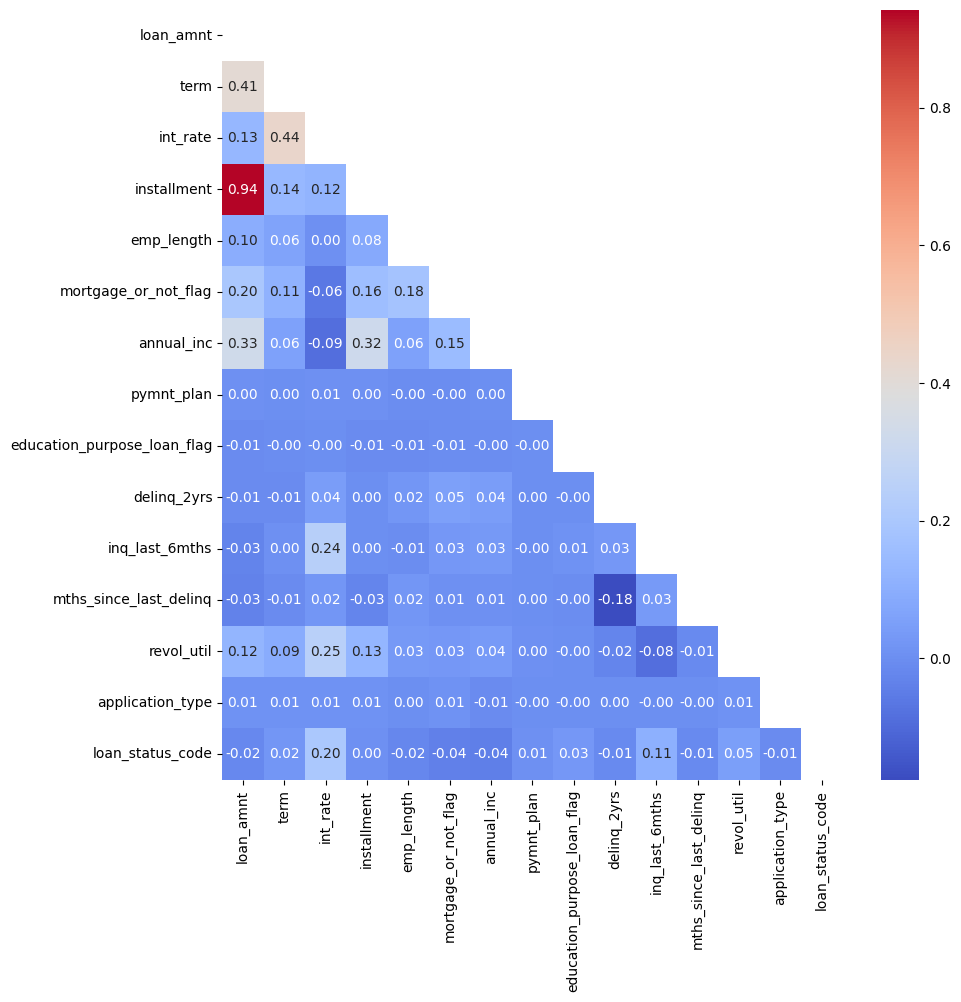

In [48]:
corr = work_df.corr()
plt.figure(figsize = (10,10))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot = True, mask=mask, cmap = 'coolwarm', fmt = ".2f")

## **Pair plot**

In [49]:
'''
sns.pairplot(work_df[['loan_amnt',
                   'installment',
                   'emp_length',
                   'term__36_months',
                   'term__60_months',
                   'pymnt_plan_n',
                   'pymnt_plan_y',
                   'loan_status_code']], hue="loan_status_code")
 '''

'\nsns.pairplot(work_df[[\'loan_amnt\',\n                   \'installment\',\n                   \'emp_length\',\n                   \'term__36_months\',\n                   \'term__60_months\',\n                   \'pymnt_plan_n\',\n                   \'pymnt_plan_y\',\n                   \'loan_status_code\']], hue="loan_status_code")\n '

# **Model**

In [50]:
'''
['loan_amnt', 'term', 'int_rate', 'installment', 'emp_length',
       'mortgage_or_not_flag', 'annual_inc', 'pymnt_plan',
       'education_purpose_loan_flag', 'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_delinq', 'revol_util', 'application_type',
       'loan_status_code']
'''

"\n['loan_amnt', 'term', 'int_rate', 'installment', 'emp_length',\n       'mortgage_or_not_flag', 'annual_inc', 'pymnt_plan',\n       'education_purpose_loan_flag', 'delinq_2yrs', 'inq_last_6mths',\n       'mths_since_last_delinq', 'revol_util', 'application_type',\n       'loan_status_code']\n"

In [51]:
feature_columns = ['loan_amnt',
                   'installment',
                   'emp_length',
                   'mortgage_or_not_flag',
                   'pymnt_plan',
                   'education_purpose_loan_flag'
                  ]
X = work_df[feature_columns]
y = df['loan_status_code']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

# standardize
sc_x = StandardScaler()

X_train_std = sc_x.fit(X_train).transform(X_train)
X_test_std = sc_x.fit(X_train).transform(X_test)

## **Logistion Regression**

In [52]:
lr_1 = LogisticRegression().fit(X_train,y_train)
y_pred_lr_1 = lr_1.predict(X_test)
metrics_lr_1 = get_metrics(y_test, y_pred_lr_1, 'LogisticRegressionClassifier_wo_std')
metrics_lr_1

{'Model': 'LogisticRegressionClassifier_wo_std',
 'Accuracy': 0.9086748800305088,
 'Balanced Accuracy': 0.5,
 'Macro Recall': 0.5,
 'Macro Precision': 0.4543374400152544,
 'Weighted Recall': 0.9086748800305088,
 'Weighted Precision': 0.8256900375984596,
 'Macro F1': 0.47607630274674345,
 'Weighted F1': 0.8651971545675305,
 'MCC Score': 0.0,
 'F2 Score': 0.8907697618946379}

Confusion Matrix for Logistic Regression Classifier


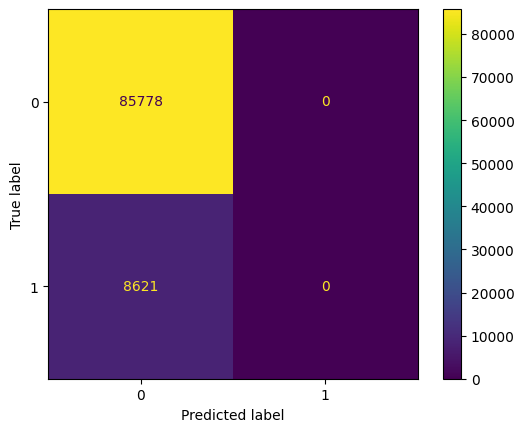

In [53]:
plot_confusion_matrix_custom(y_test, y_pred_lr_1, lr_1.classes_, title = 'Confusion Matrix for Logistic Regression Classifier')

In [54]:
print(classification_report(y_test, y_pred_lr_1))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     85778
           1       0.00      0.00      0.00      8621

    accuracy                           0.91     94399
   macro avg       0.45      0.50      0.48     94399
weighted avg       0.83      0.91      0.87     94399



## **KNN Classifier**

In [55]:
knn_1 = KNeighborsClassifier(n_neighbors=5).fit(X_train_std,y_train)
y_pred_knn_1 = knn_1.predict(X_test_std)
metrics_knn_1 = get_metrics(y_test, y_pred_knn_1, 'KNNClassifier_w_std')
metrics_knn_1

{'Model': 'KNNClassifier_w_std',
 'Accuracy': 0.8991832540598947,
 'Balanced Accuracy': 0.5174185232514263,
 'Macro Recall': 0.5174185232514263,
 'Macro Precision': 0.5788263118348939,
 'Weighted Recall': 0.8991832540598947,
 'Weighted Precision': 0.8508358703437073,
 'Macro F1': 0.5151197820318127,
 'Weighted F1': 0.8678370114372778,
 'MCC Score': 0.07410905330714421,
 'F2 Score': 0.8859755837418207}

Confusion Matrix for KNN Classifier


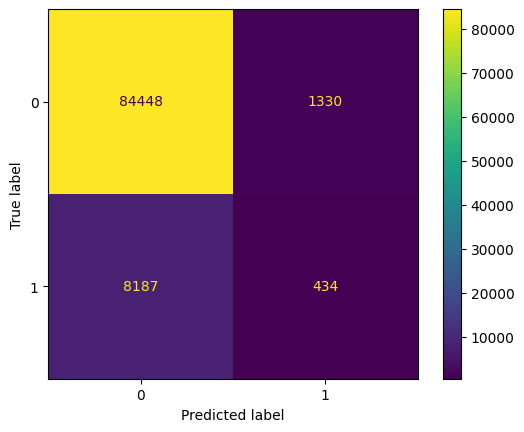

In [56]:
plot_confusion_matrix_custom(y_test, y_pred_knn_1, knn_1.classes_, title = 'Confusion Matrix for KNN Classifier')

In [57]:
print(classification_report(y_test, y_pred_knn_1))

              precision    recall  f1-score   support

           0       0.91      0.98      0.95     85778
           1       0.25      0.05      0.08      8621

    accuracy                           0.90     94399
   macro avg       0.58      0.52      0.52     94399
weighted avg       0.85      0.90      0.87     94399



## **Decission Tree Classifier**

In [58]:
dt_1 = DecisionTreeClassifier().fit(X_train,y_train)
y_pred_dt_1 = dt_1.predict(X_test)
metrics_dt_1 = get_metrics(y_test, y_pred_dt_1, 'DecisionTreeClassifier_wo_std')
metrics_dt_1

{'Model': 'DecisionTreeClassifier_wo_std',
 'Accuracy': 0.8736427292661999,
 'Balanced Accuracy': 0.5497951345359672,
 'Macro Recall': 0.5497951345359672,
 'Macro Precision': 0.5699149947628941,
 'Weighted Recall': 0.8736427292661999,
 'Weighted Precision': 0.8540100960621165,
 'Macro F1': 0.5566020615583879,
 'Weighted F1': 0.8630539212771612,
 'MCC Score': 0.11800722978359844,
 'F2 Score': 0.8692569754590382}

Confusion Matrix for Decission Tree Classifier


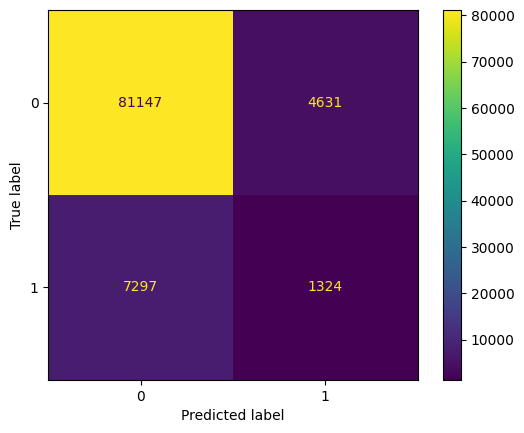

In [59]:
plot_confusion_matrix_custom(y_test, y_pred_dt_1, dt_1.classes_, title = 'Confusion Matrix for Decission Tree Classifier')

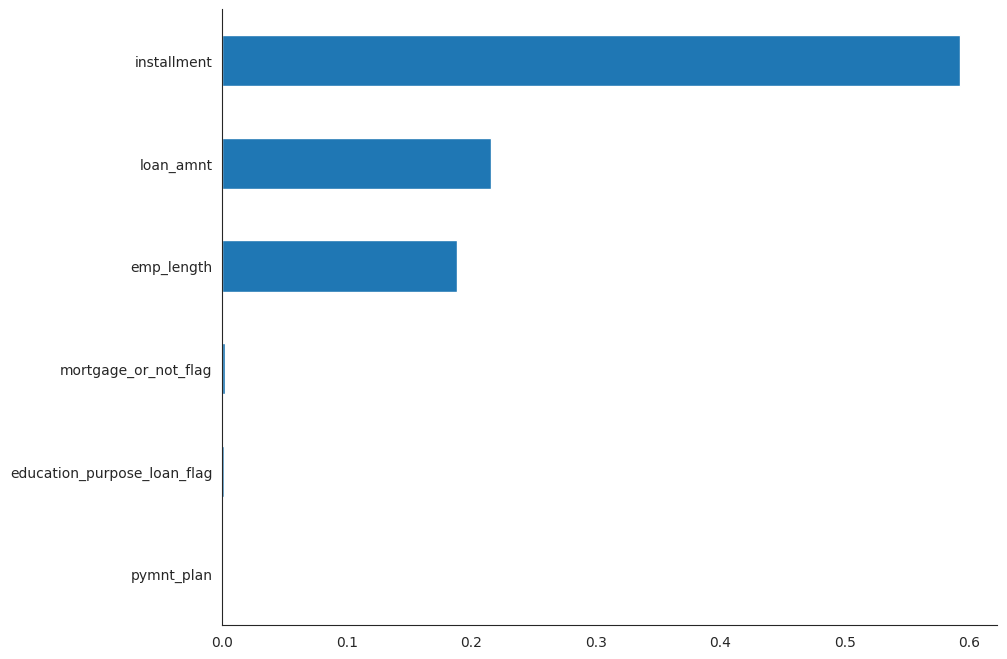

In [60]:
plt.rcParams['figure.figsize']=10,8
sns.set_style("white")
feat_importances = pd.Series(dt_1.feature_importances_, index=dt_1.feature_names_in_)
feat_importances = feat_importances.groupby(level=0).mean()
feat_importances.nlargest(20).plot(kind='barh').invert_yaxis()
sns.despine()
plt.show()

In [61]:
print(classification_report(y_test, y_pred_dt_1))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93     85778
           1       0.22      0.15      0.18      8621

    accuracy                           0.87     94399
   macro avg       0.57      0.55      0.56     94399
weighted avg       0.85      0.87      0.86     94399



## **Decision Tree Classifier with Over Sampling**

In [62]:
oversample = RandomOverSampler(random_state=1234)
X_train_ov_smpl, y_train_ov_smpl = oversample.fit_resample(X_train, y_train)
dt_2 = DecisionTreeClassifier().fit(X_train_ov_smpl, y_train_ov_smpl)
y_pred_dt_2 = dt_2.predict(X_test)
metrics_dt_2 = get_metrics(y_test, y_pred_dt_2, 'DecisionTreeClassifier_w_ov_smpl')
metrics_dt_2

{'Model': 'DecisionTreeClassifier_w_ov_smpl',
 'Accuracy': 0.7970105615525588,
 'Balanced Accuracy': 0.5632923740427921,
 'Macro Recall': 0.5632923740427921,
 'Macro Precision': 0.5386274867990315,
 'Weighted Recall': 0.7970105615525588,
 'Weighted Precision': 0.8513353264106249,
 'Macro F1': 0.5417399096320327,
 'Weighted F1': 0.8212930668278604,
 'MCC Score': 0.09889035024343501,
 'F2 Score': 0.8058523741221204}

Confusion Matrix for Decision Tree Classifier with Over Sampling


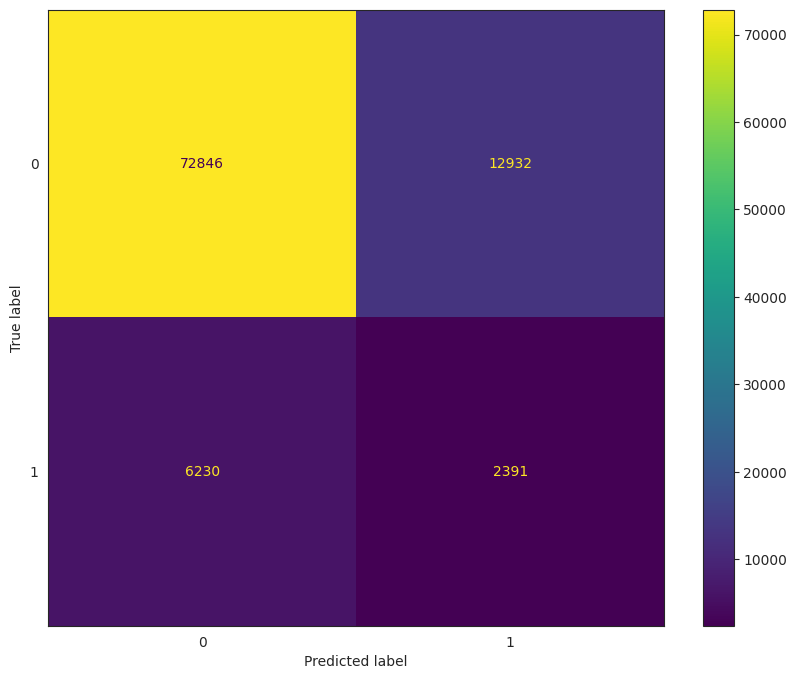

In [63]:
plot_confusion_matrix_custom(y_test, y_pred_dt_2, dt_2.classes_, title = 'Confusion Matrix for Decision Tree Classifier with Over Sampling')

In [64]:
print(classification_report(y_test, y_pred_dt_2))

              precision    recall  f1-score   support

           0       0.92      0.85      0.88     85778
           1       0.16      0.28      0.20      8621

    accuracy                           0.80     94399
   macro avg       0.54      0.56      0.54     94399
weighted avg       0.85      0.80      0.82     94399



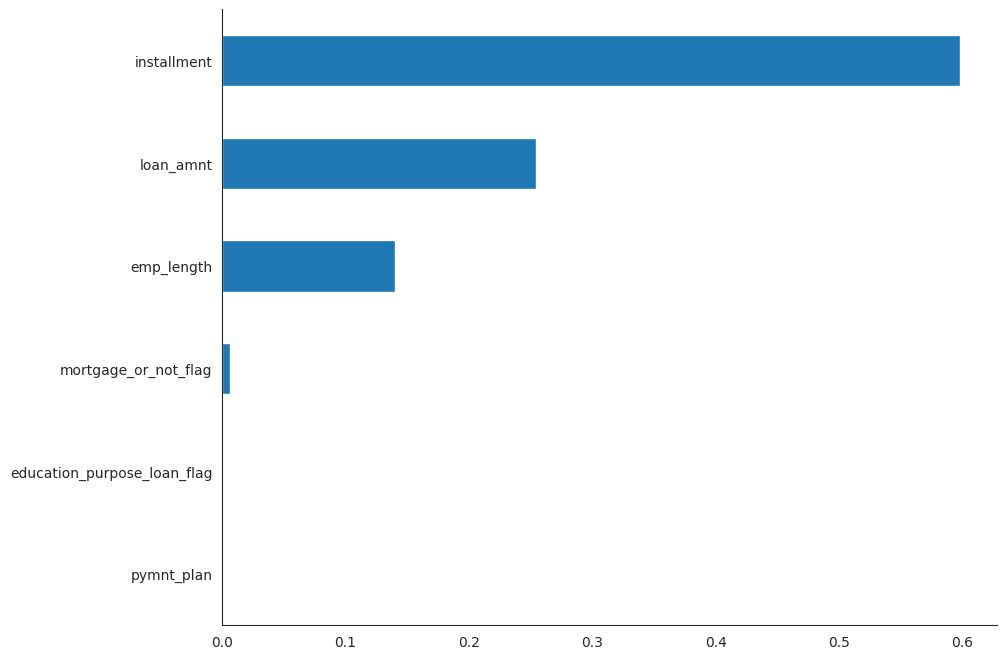

In [65]:
plt.rcParams['figure.figsize']=10,8
sns.set_style("white")
feat_importances = pd.Series(dt_2.feature_importances_, index=dt_2.feature_names_in_)
feat_importances = feat_importances.groupby(level=0).mean()
feat_importances.nlargest(20).plot(kind='barh').invert_yaxis()
sns.despine()
plt.show()

## **Gradient Boost Classifier**

In [66]:
# Gradient Boost Classifier, Balanced
gbc_1 = GradientBoostingClassifier(random_state=1234)

# Fit pipeline with sample weights
#weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
gbc_1.fit(X_train_std, y_train)

# Step 1: Generate Predictions
y_pred_gbc_1 = gbc_1.predict(X_test_std)

# Step 2: Evaluate Metrics
metrics_gbc_1 = get_metrics(y_test, y_pred_gbc_1, 'GradientBoostingClassifier_w_std')

# Step 3: View Results
metrics_gbc_1

{'Model': 'GradientBoostingClassifier_w_std',
 'Accuracy': 0.9087808133560736,
 'Balanced Accuracy': 0.5006321480323839,
 'Macro Recall': 0.5006321480323839,
 'Macro Precision': 0.9127232387228468,
 'Weighted Recall': 0.9087808133560736,
 'Weighted Precision': 0.9095000788391475,
 'Macro F1': 0.477376642102681,
 'Weighted F1': 0.8654774237807122,
 'MCC Score': 0.03230493357230272,
 'F2 Score': 0.8909294172660284}

Confusion Matrix for GradientBoostingClassifier


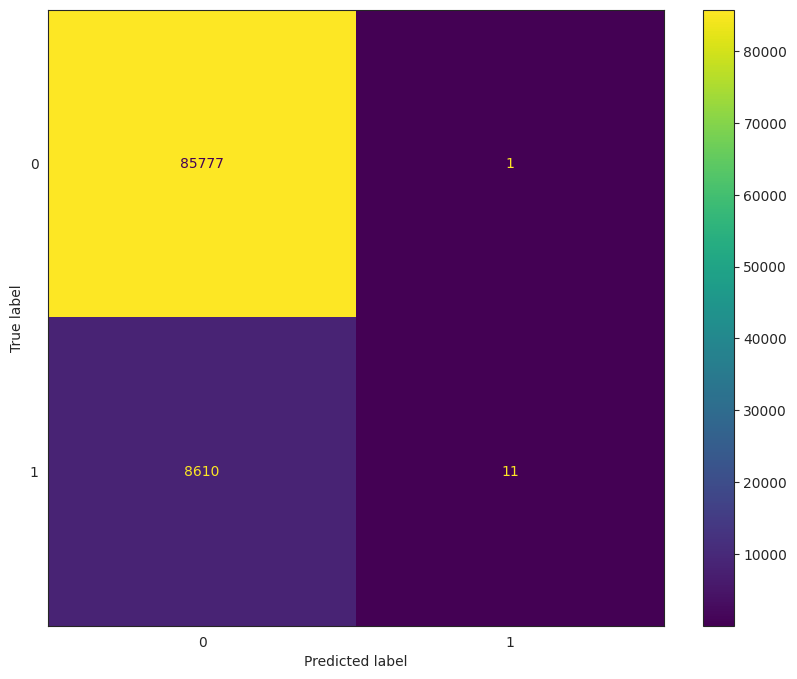

In [67]:
plot_confusion_matrix_custom(y_test, y_pred_gbc_1, gbc_1.classes_, title = 'Confusion Matrix for GradientBoostingClassifier')

In [68]:
print(classification_report(y_test, y_pred_gbc_1))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     85778
           1       0.92      0.00      0.00      8621

    accuracy                           0.91     94399
   macro avg       0.91      0.50      0.48     94399
weighted avg       0.91      0.91      0.87     94399



## **Random Forest Classifier**

In [69]:
# Random Forest Classifier, Balanced
rf_1 = RandomForestClassifier(random_state=1234)

# Fit pipeline with sample weights
rf_1.fit(X_train, y_train)

# Step 1: Generate Predictions
y_pred_rf_1 = rf_1.predict(X_test)

# Step 2: Evaluate Metrics
metrics_rf_1 = get_metrics(y_test, y_pred_rf_1, 'RandomForestClassifier_wo_std')

# Step 3: View Results
metrics_rf_1

{'Model': 'RandomForestClassifier_wo_std',
 'Accuracy': 0.8897551880846195,
 'Balanced Accuracy': 0.5315853790726847,
 'Macro Recall': 0.5315853790726847,
 'Macro Precision': 0.5755781511208933,
 'Weighted Recall': 0.8897551880846195,
 'Weighted Precision': 0.852279301040537,
 'Macro F1': 0.5375537087332535,
 'Weighted F1': 0.8674171442205365,
 'MCC Score': 0.09771723599787414,
 'F2 Score': 0.8803250137671099}

Confusion Matrix for RandomForestClassifier


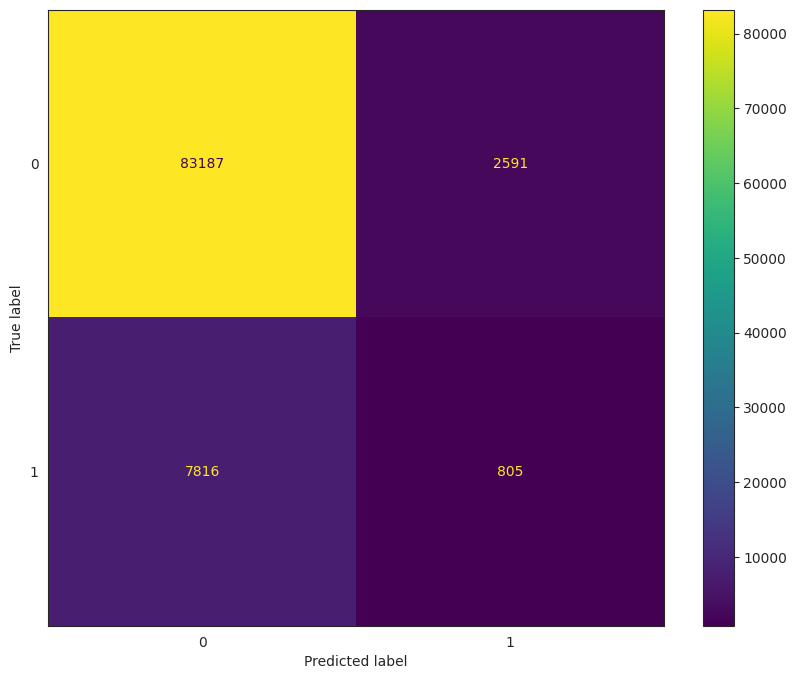

In [70]:
plot_confusion_matrix_custom(y_test, y_pred_rf_1, rf_1.classes_, title = 'Confusion Matrix for RandomForestClassifier')

In [71]:
print(classification_report(y_test, y_pred_rf_1))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94     85778
           1       0.24      0.09      0.13      8621

    accuracy                           0.89     94399
   macro avg       0.58      0.53      0.54     94399
weighted avg       0.85      0.89      0.87     94399



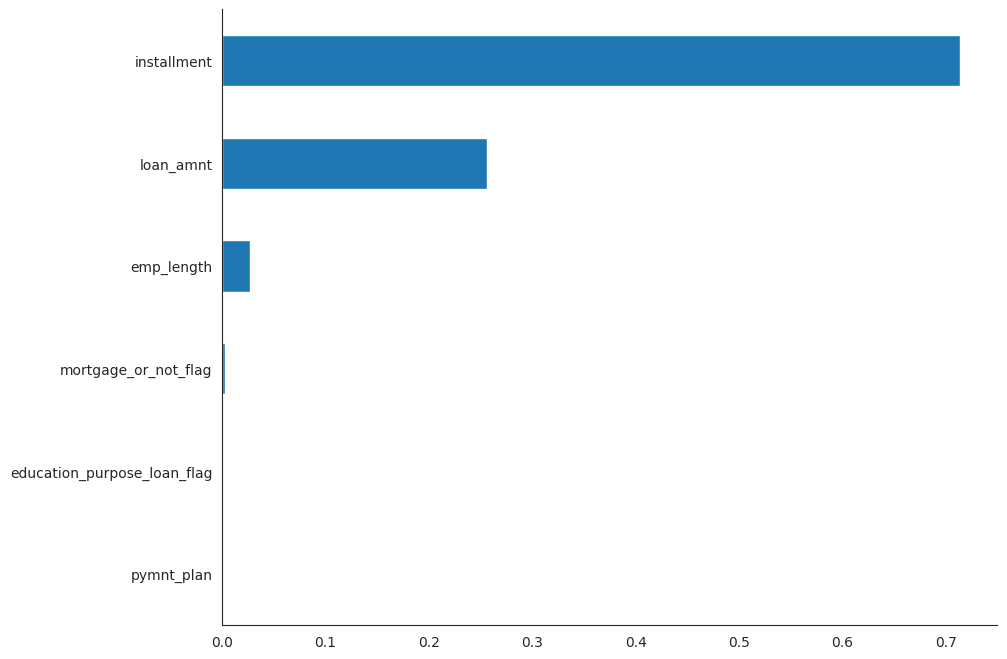

In [72]:
plt.rcParams['figure.figsize']=10,8
sns.set_style("white")
feat_importances = pd.Series(rf_1.feature_importances_, index=rf_1.feature_names_in_)
feat_importances = feat_importances.groupby(level=0).mean()
feat_importances.nlargest(20).plot(kind='barh').invert_yaxis()
sns.despine()
plt.show()

## **Support Vector Classifier**

In [73]:
'''
svc_1 = SVC().fit(X_train_std,y_train)
y_pred_svc_1 = svc_1.predict(X_test_std)
metrics_svc_1 = get_metrics(y_test, y_pred_svc_1, 'SVClassifier_w_std')
metrics_svc_1
plot_confusion_matrix_custom(y_test, y_pred_svc_1, svc_1.classes_, title = 'Confusion Matrix for Support Vector Classifier')
print(classification_report(y_test, y_pred_svc_1))
'''

"\nsvc_1 = SVC().fit(X_train_std,y_train)\ny_pred_svc_1 = svc_1.predict(X_test_std)\nmetrics_svc_1 = get_metrics(y_test, y_pred_svc_1, 'SVClassifier_w_std')\nmetrics_svc_1\nplot_confusion_matrix_custom(y_test, y_pred_svc_1, svc_1.classes_, title = 'Confusion Matrix for Support Vector Classifier')\nprint(classification_report(y_test, y_pred_svc_1))\n"

## **XGBoost Classifier**

In [74]:
xgbc_1 = xgb.XGBClassifier()
xgbc_1.fit(X_train, y_train)
y_pred_xgbc_1 = xgbc_1.predict(X_test)
metrics_xgbc_1 = get_metrics(y_test, y_pred_xgbc_1, 'XGBClassifier_wo_std')
metrics_xgbc_1

{'Model': 'XGBClassifier_wo_std',
 'Accuracy': 0.9088125933537432,
 'Balanced Accuracy': 0.5032580806153208,
 'Macro Recall': 0.5032580806153208,
 'Macro Precision': 0.7344246376346252,
 'Weighted Recall': 0.9088125933537432,
 'Weighted Precision': 0.8772905182200936,
 'Macro F1': 0.4830853183350029,
 'Weighted F1': 0.8665126883127189,
 'MCC Score': 0.05527293614893263,
 'F2 Score': 0.891298352254364}

Confusion Matrix for XGB Classifier without Standardization


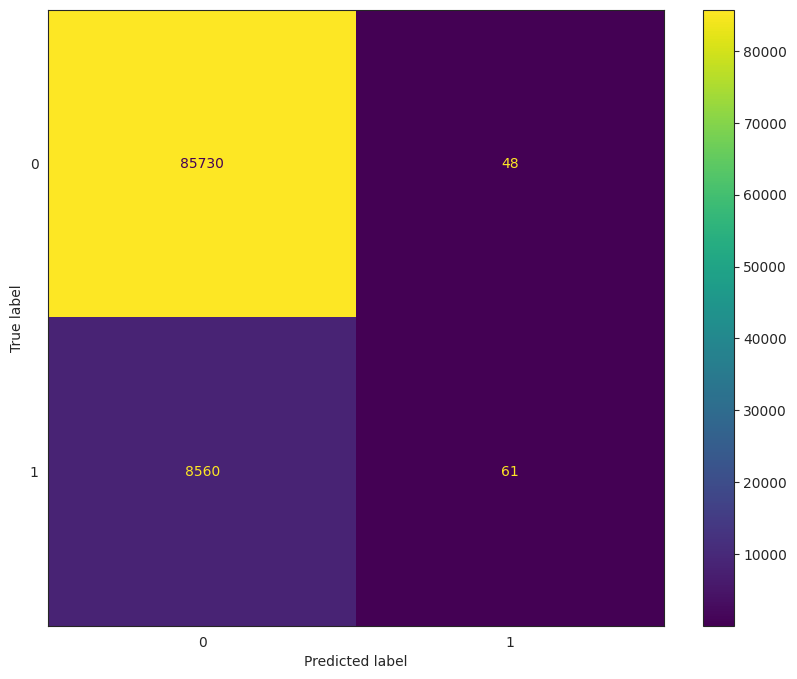

In [75]:
plot_confusion_matrix_custom(y_test, y_pred_xgbc_1, xgbc_1.classes_, title = 'Confusion Matrix for XGB Classifier without Standardization')

In [76]:
print(classification_report(y_test, y_pred_xgbc_1))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     85778
           1       0.56      0.01      0.01      8621

    accuracy                           0.91     94399
   macro avg       0.73      0.50      0.48     94399
weighted avg       0.88      0.91      0.87     94399



## **LightGBM Classifier**

In [77]:
lgbc_1 = lgb.LGBMClassifier()
lgbc_1.fit(X_train, y_train)
y_pred_lgbc_1 = lgbc_1.predict(X_test)
metrics_lgbc_1 = get_metrics(y_test, y_pred_lgbc_1, 'LGBClassifier_wo_std')
metrics_lgbc_1

[LightGBM] [Info] Number of positive: 34484, number of negative: 343109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004424 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 525
[LightGBM] [Info] Number of data points in the train set: 377593, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091326 -> initscore=-2.297553
[LightGBM] [Info] Start training from score -2.297553


{'Model': 'LGBClassifier_wo_std',
 'Accuracy': 0.9088231866862997,
 'Balanced Accuracy': 0.5012293220621096,
 'Macro Recall': 0.5012293220621096,
 'Macro Precision': 0.8211061542102456,
 'Weighted Recall': 0.9088231866862997,
 'Weighted Precision': 0.8928472482938686,
 'Macro F1': 0.4786542344789785,
 'Weighted F1': 0.8657250214997868,
 'MCC Score': 0.039736274593868186,
 'F2 Score': 0.8910388268774397}

Confusion Matrix for LGB Classifier without Standardization


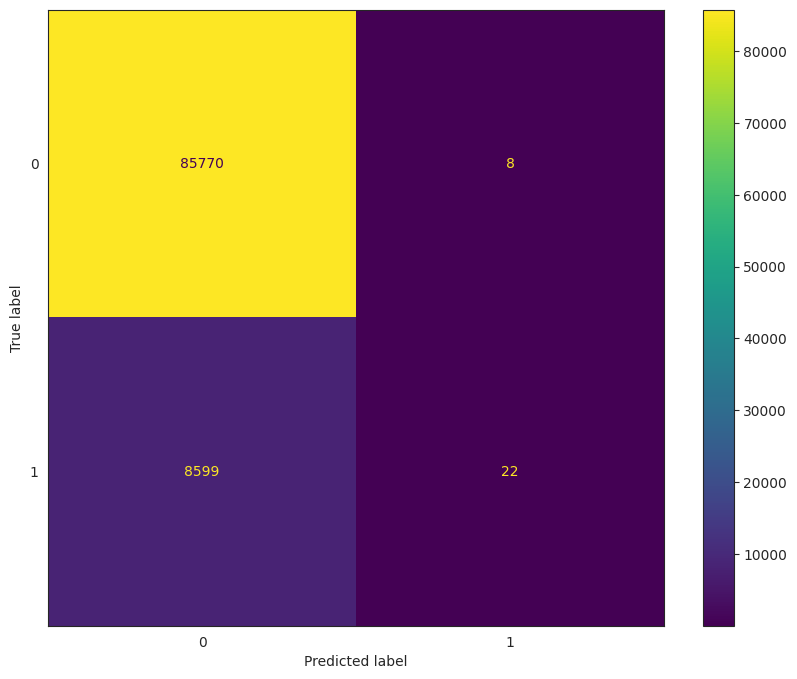

In [78]:
plot_confusion_matrix_custom(y_test, y_pred_lgbc_1, lgbc_1.classes_, title = 'Confusion Matrix for LGB Classifier without Standardization')

In [79]:
print(classification_report(y_test, y_pred_lgbc_1))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     85778
           1       0.73      0.00      0.01      8621

    accuracy                           0.91     94399
   macro avg       0.82      0.50      0.48     94399
weighted avg       0.89      0.91      0.87     94399



## **MLP Classifier**

In [80]:
mlpc_1 = MLPClassifier(hidden_layer_sizes = (5,5,5),
                      activation='relu',
                      solver='adam',
                      batch_size=32,
                      verbose=0).fit(X_train,y_train)
y_pred_mlpc_1 = mlpc_1.predict(X_test)
metrics_mlpc_1 = get_metrics(y_test, y_pred_mlpc_1, 'MLPClassifier_wo_std')
metrics_mlpc_1

{'Model': 'MLPClassifier_wo_std',
 'Accuracy': 0.9086748800305088,
 'Balanced Accuracy': 0.5,
 'Macro Recall': 0.5,
 'Macro Precision': 0.4543374400152544,
 'Weighted Recall': 0.9086748800305088,
 'Weighted Precision': 0.8256900375984596,
 'Macro F1': 0.47607630274674345,
 'Weighted F1': 0.8651971545675305,
 'MCC Score': 0.0,
 'F2 Score': 0.8907697618946379}

Confusion Matrix for MLP Classifier


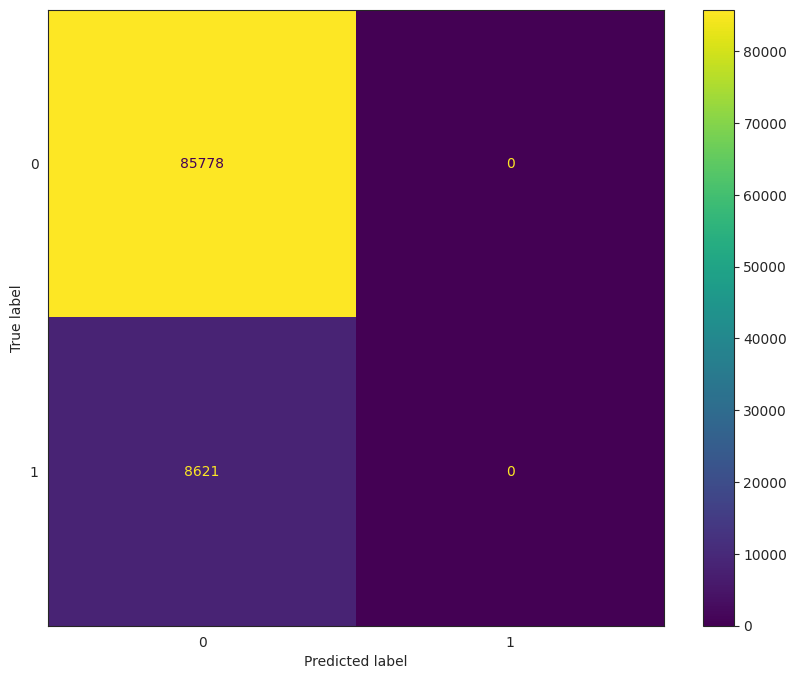

In [81]:
plot_confusion_matrix_custom(y_test, y_pred_mlpc_1, mlpc_1.classes_, title = 'Confusion Matrix for MLP Classifier')

In [82]:
print(classification_report(y_test, y_pred_mlpc_1))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     85778
           1       0.00      0.00      0.00      8621

    accuracy                           0.91     94399
   macro avg       0.45      0.50      0.48     94399
weighted avg       0.83      0.91      0.87     94399



# **Models Comparison**

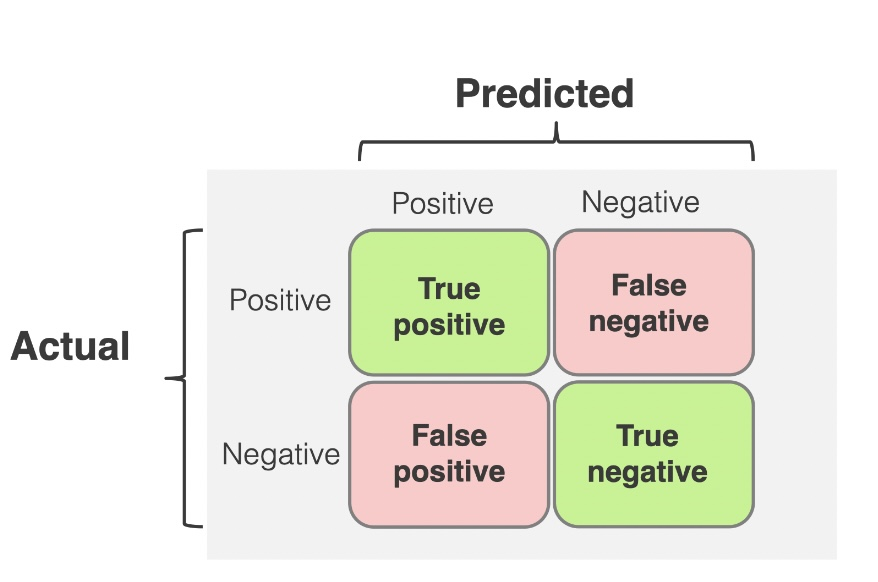

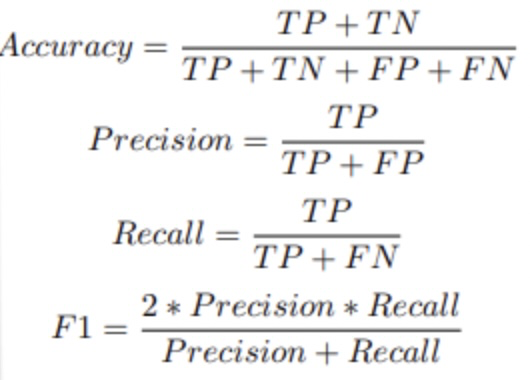

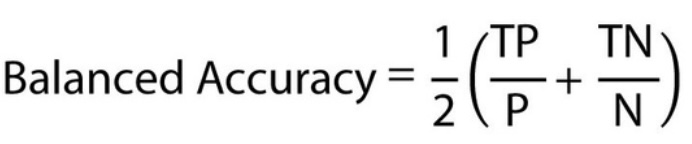

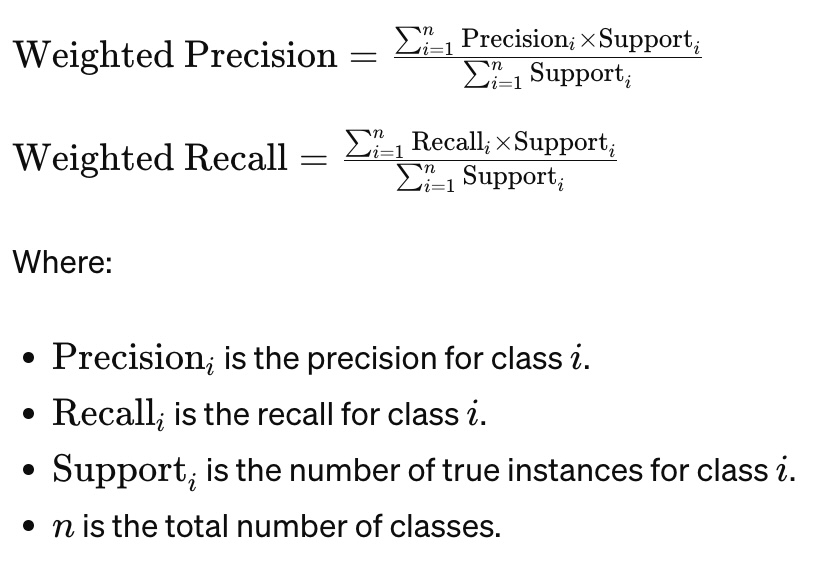

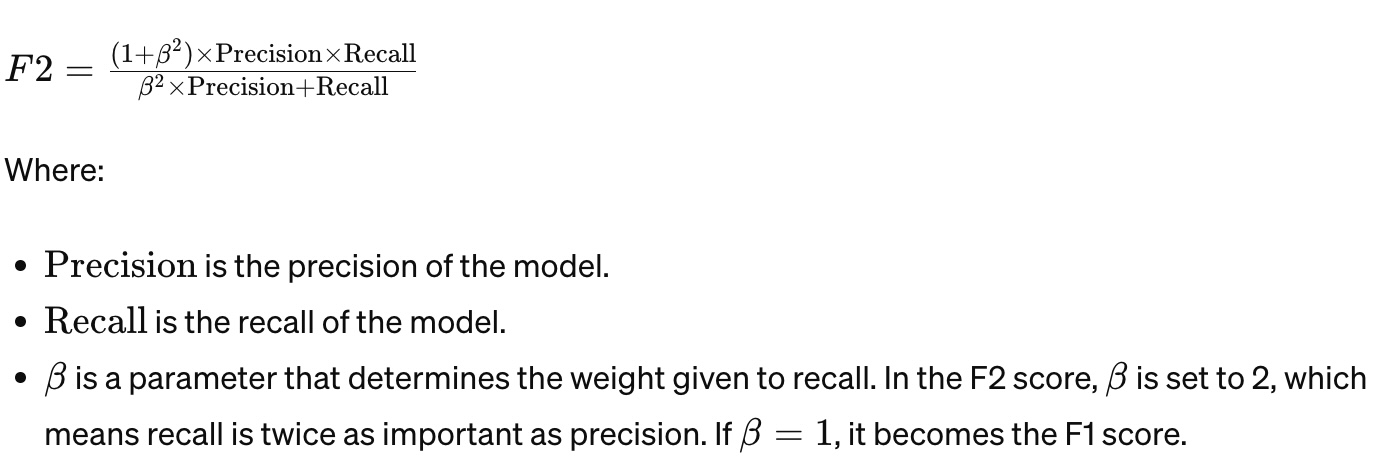

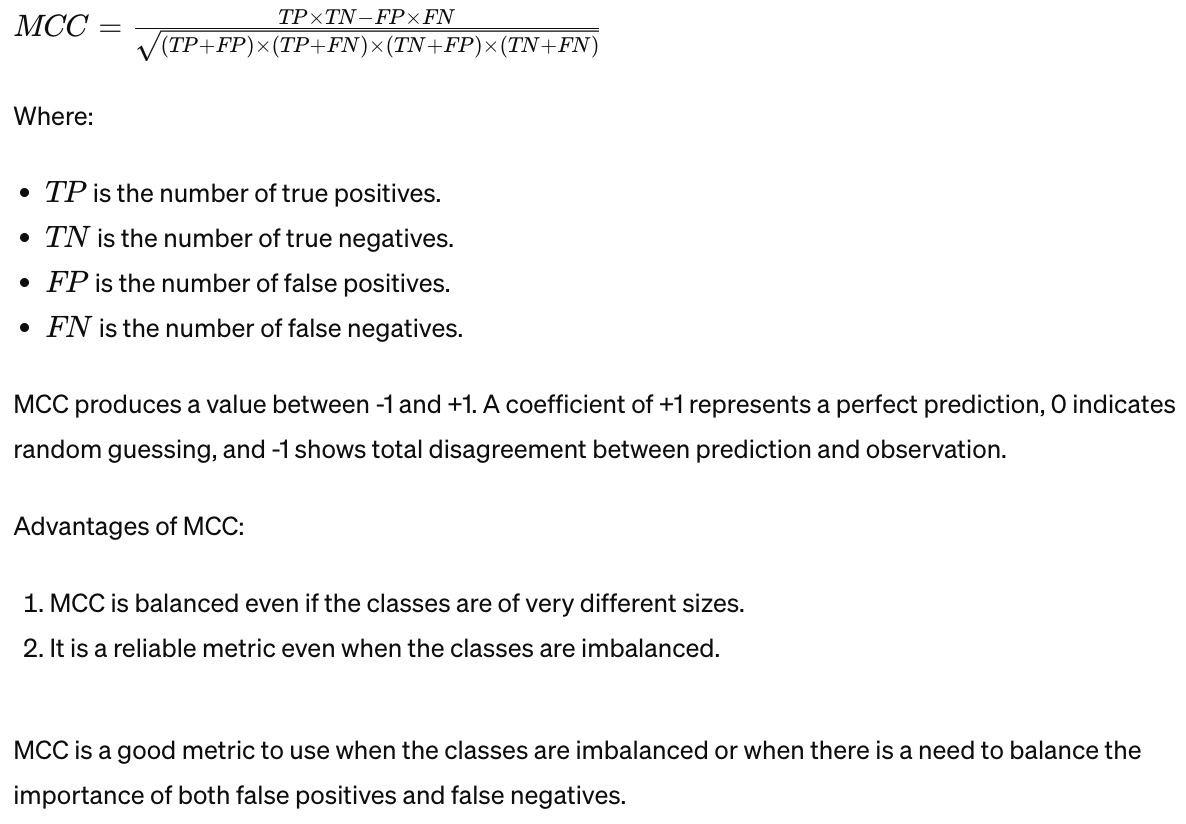

In [84]:
pd.DataFrame({'metrics_lr_1':pd.Series(metrics_lr_1),
              'metrics_knn_1':pd.Series(metrics_knn_1),
              'metrics_gbc_1':pd.Series(metrics_gbc_1),
              'metrics_dt_1':pd.Series(metrics_dt_1),
              'metrics_dt_2':pd.Series(metrics_dt_2),
              'metrics_xgbc_1':pd.Series(metrics_xgbc_1),
              'metrics_lgbc_1':pd.Series(metrics_lgbc_1),
              'metrics_rf_1':pd.Series(metrics_rf_1),
              'metrics_mlpc_1':pd.Series(metrics_mlpc_1)
             }
            ).iloc[1:,:].T

,Accuracy,Balanced Accuracy,Macro Recall,Macro Precision,Weighted Recall,Weighted Precision,Macro F1,Weighted F1,MCC Score,F2 Score
metrics_lr_1,0.908675,0.5,0.5,0.454337,0.908675,0.82569,0.476076,0.865197,0.0,0.89077
metrics_knn_1,0.899183,0.517419,0.517419,0.578826,0.899183,0.850836,0.51512,0.867837,0.074109,0.885976
metrics_gbc_1,0.908781,0.500632,0.500632,0.912723,0.908781,0.9095,0.477377,0.865477,0.032305,0.890929
metrics_dt_1,0.873643,0.549795,0.549795,0.569915,0.873643,0.85401,0.556602,0.863054,0.118007,0.869257
metrics_dt_2,0.797011,0.563292,0.563292,0.538627,0.797011,0.851335,0.54174,0.821293,0.09889,0.805852
metrics_xgbc_1,0.908813,0.503258,0.503258,0.734425,0.908813,0.877291,0.483085,0.866513,0.055273,0.891298
metrics_lgbc_1,0.908823,0.501229,0.501229,0.821106,0.908823,0.892847,0.478654,0.865725,0.039736,0.891039
metrics_rf_1,0.889755,0.531585,0.531585,0.575578,0.889755,0.852279,0.537554,0.867417,0.097717,0.880325
metrics_mlpc_1,0.908675,0.5,0.5,0.454337,0.908675,0.82569,0.476076,0.865197,0.0,0.89077


# **Model iteration**

In [85]:
'''
['loan_amnt', 'term', 'int_rate', 'installment', 'emp_length',
       'mortgage_or_not_flag', 'annual_inc', 'pymnt_plan',
       'education_purpose_loan_flag', 'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_delinq', 'revol_util', 'application_type',
       'loan_status_code']
'''

"\n['loan_amnt', 'term', 'int_rate', 'installment', 'emp_length',\n       'mortgage_or_not_flag', 'annual_inc', 'pymnt_plan',\n       'education_purpose_loan_flag', 'delinq_2yrs', 'inq_last_6mths',\n       'mths_since_last_delinq', 'revol_util', 'application_type',\n       'loan_status_code']\n"

In [86]:
feature_columns = ['loan_amnt',
                   'installment',
                   'emp_length'
                  ]
X = work_df[feature_columns]
y = df['loan_status_code']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

# standardize
sc_x = StandardScaler()

X_train_std = sc_x.fit(X_train).transform(X_train)
X_test_std = sc_x.fit(X_train).transform(X_test)

## **Logistion Regression**

In [87]:
lr_1 = LogisticRegression().fit(X_train,y_train)
y_pred_lr_1 = lr_1.predict(X_test)
metrics_lr_1 = get_metrics(y_test, y_pred_lr_1, 'LogisticRegressionClassifier_wo_std')
metrics_lr_1

{'Model': 'LogisticRegressionClassifier_wo_std',
 'Accuracy': 0.9086748800305088,
 'Balanced Accuracy': 0.5,
 'Macro Recall': 0.5,
 'Macro Precision': 0.4543374400152544,
 'Weighted Recall': 0.9086748800305088,
 'Weighted Precision': 0.8256900375984596,
 'Macro F1': 0.47607630274674345,
 'Weighted F1': 0.8651971545675305,
 'MCC Score': 0.0,
 'F2 Score': 0.8907697618946379}

Confusion Matrix for Logistic Regression Classifier


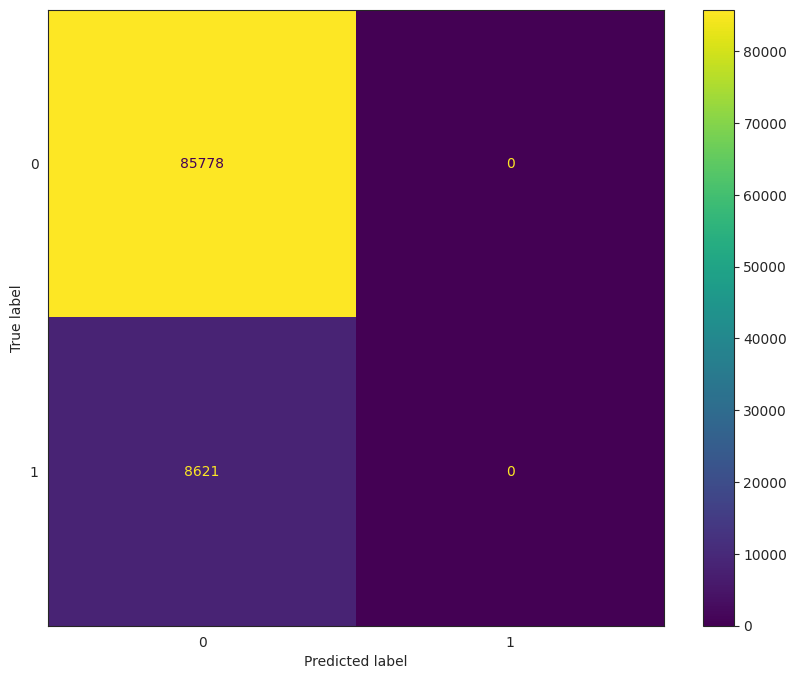

In [88]:
plot_confusion_matrix_custom(y_test, y_pred_lr_1, lr_1.classes_, title = 'Confusion Matrix for Logistic Regression Classifier')

In [89]:
print(classification_report(y_test, y_pred_lr_1))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     85778
           1       0.00      0.00      0.00      8621

    accuracy                           0.91     94399
   macro avg       0.45      0.50      0.48     94399
weighted avg       0.83      0.91      0.87     94399



## **KNN Classifier**

In [90]:
knn_1 = KNeighborsClassifier(n_neighbors=5).fit(X_train_std,y_train)
y_pred_knn_1 = knn_1.predict(X_test_std)
metrics_knn_1 = get_metrics(y_test, y_pred_knn_1, 'KNNClassifier_w_std')
metrics_knn_1

{'Model': 'KNNClassifier_w_std',
 'Accuracy': 0.8988230807529741,
 'Balanced Accuracy': 0.5218112014599944,
 'Macro Recall': 0.5218112014599944,
 'Macro Precision': 0.5884049418200743,
 'Weighted Recall': 0.8988230807529741,
 'Weighted Precision': 0.8531994973876827,
 'Macro F1': 0.5224704330692403,
 'Weighted F1': 0.8689722854549718,
 'MCC Score': 0.08782295818512893,
 'F2 Score': 0.8861981523707289}

Confusion Matrix for KNN Classifier


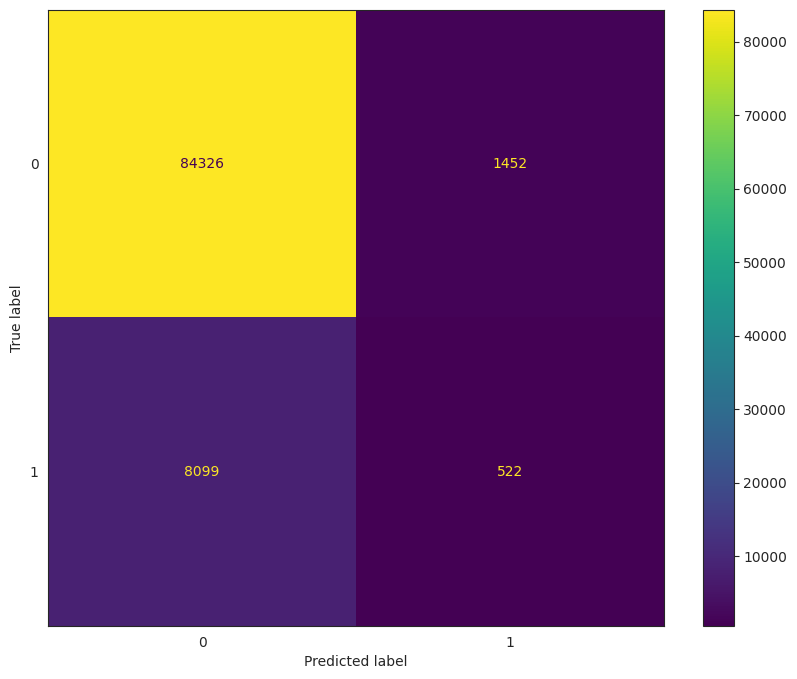

In [91]:
plot_confusion_matrix_custom(y_test, y_pred_knn_1, knn_1.classes_, title = 'Confusion Matrix for KNN Classifier')

In [92]:
print(classification_report(y_test, y_pred_knn_1))

              precision    recall  f1-score   support

           0       0.91      0.98      0.95     85778
           1       0.26      0.06      0.10      8621

    accuracy                           0.90     94399
   macro avg       0.59      0.52      0.52     94399
weighted avg       0.85      0.90      0.87     94399



## **Decission Tree Classifier**

In [93]:
dt_1 = DecisionTreeClassifier().fit(X_train,y_train)
y_pred_dt_1 = dt_1.predict(X_test)
metrics_dt_1 = get_metrics(y_test, y_pred_dt_1, 'DecisionTreeClassifier_wo_std')
metrics_dt_1

{'Model': 'DecisionTreeClassifier_wo_std',
 'Accuracy': 0.8797550821512939,
 'Balanced Accuracy': 0.5516455693542478,
 'Macro Recall': 0.5516455693542478,
 'Macro Precision': 0.5805897234329551,
 'Weighted Recall': 0.8797550821512939,
 'Weighted Precision': 0.8561744556125521,
 'Macro F1': 0.560433519845522,
 'Weighted F1': 0.8666540794272473,
 'MCC Score': 0.12902871232088362,
 'F2 Score': 0.8742781264850721}

Confusion Matrix for Decission Tree Classifier


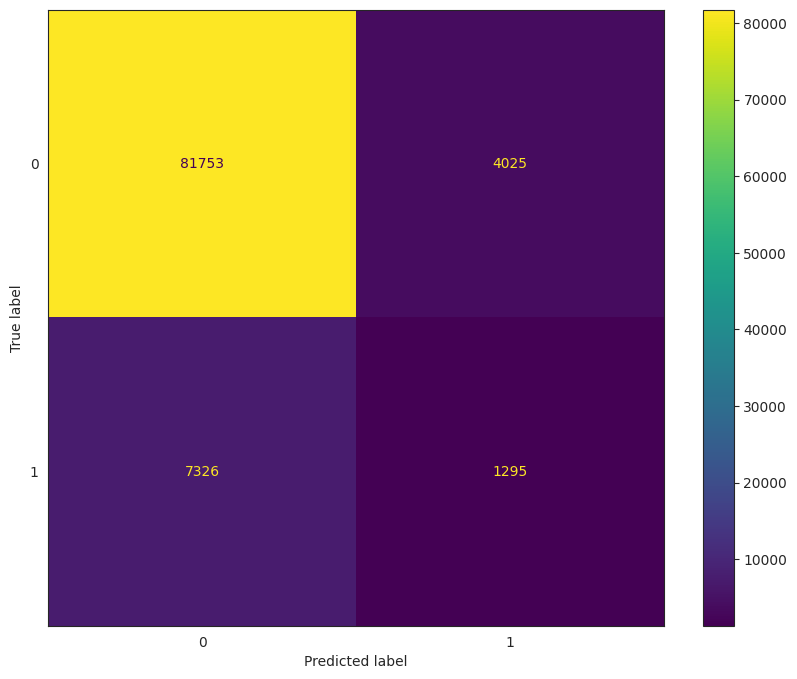

In [94]:
plot_confusion_matrix_custom(y_test, y_pred_dt_1, dt_1.classes_, title = 'Confusion Matrix for Decission Tree Classifier')

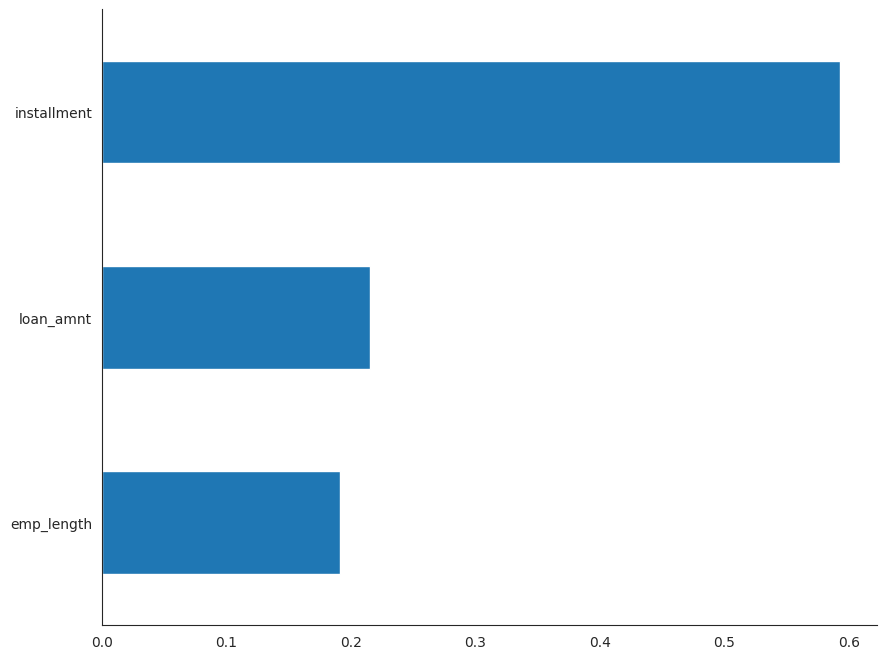

In [95]:
plt.rcParams['figure.figsize']=10,8
sns.set_style("white")
feat_importances = pd.Series(dt_1.feature_importances_, index=dt_1.feature_names_in_)
feat_importances = feat_importances.groupby(level=0).mean()
feat_importances.nlargest(20).plot(kind='barh').invert_yaxis()
sns.despine()
plt.show()

In [96]:
print(classification_report(y_test, y_pred_dt_1))

              precision    recall  f1-score   support

           0       0.92      0.95      0.94     85778
           1       0.24      0.15      0.19      8621

    accuracy                           0.88     94399
   macro avg       0.58      0.55      0.56     94399
weighted avg       0.86      0.88      0.87     94399



## **Decision Tree Classifier with Over Sampling**

In [97]:
oversample = RandomOverSampler(random_state=1234)
X_train_ov_smpl, y_train_ov_smpl = oversample.fit_resample(X_train, y_train)
dt_2 = DecisionTreeClassifier().fit(X_train_ov_smpl, y_train_ov_smpl)
y_pred_dt_2 = dt_2.predict(X_test)
metrics_dt_2 = get_metrics(y_test, y_pred_dt_2, 'DecisionTreeClassifier_w_ov_smpl')
metrics_dt_2

{'Model': 'DecisionTreeClassifier_w_ov_smpl',
 'Accuracy': 0.7863218890030614,
 'Balanced Accuracy': 0.5785393218068263,
 'Macro Recall': 0.5785393218068263,
 'Macro Precision': 0.5438552284086757,
 'Weighted Recall': 0.7863218890030614,
 'Weighted Precision': 0.8550587571699004,
 'Macro F1': 0.5466667834686623,
 'Weighted F1': 0.8160745137810004,
 'MCC Score': 0.11737733847554818,
 'F2 Score': 0.7967717912675835}

Confusion Matrix for Decision Tree Classifier with Over Sampling


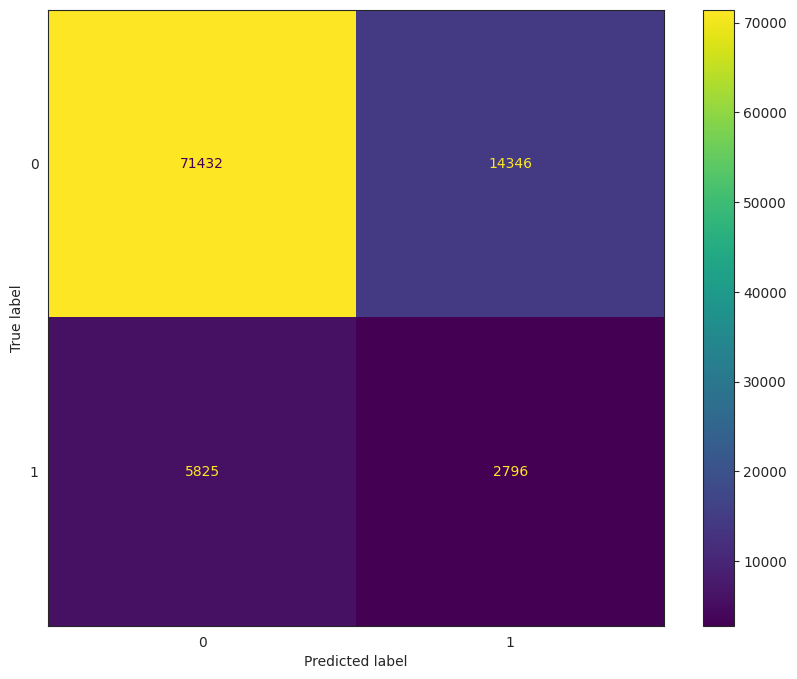

In [98]:
plot_confusion_matrix_custom(y_test, y_pred_dt_2, dt_2.classes_, title = 'Confusion Matrix for Decision Tree Classifier with Over Sampling')

In [99]:
print(classification_report(y_test, y_pred_dt_2))

              precision    recall  f1-score   support

           0       0.92      0.83      0.88     85778
           1       0.16      0.32      0.22      8621

    accuracy                           0.79     94399
   macro avg       0.54      0.58      0.55     94399
weighted avg       0.86      0.79      0.82     94399



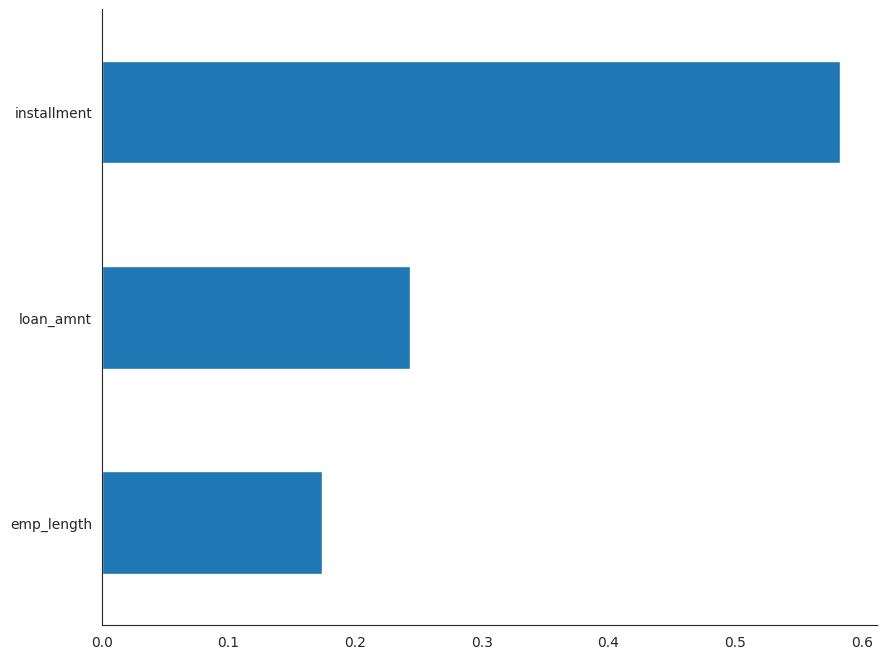

In [100]:
plt.rcParams['figure.figsize']=10,8
sns.set_style("white")
feat_importances = pd.Series(dt_2.feature_importances_, index=dt_2.feature_names_in_)
feat_importances = feat_importances.groupby(level=0).mean()
feat_importances.nlargest(20).plot(kind='barh').invert_yaxis()
sns.despine()
plt.show()

## **Gradient Boost Classifier**

In [101]:
# Gradient Boost Classifier, Balanced
gbc_1 = GradientBoostingClassifier(random_state=1234)

# Fit pipeline with sample weights
#weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
gbc_1.fit(X_train_std, y_train)

# Step 1: Generate Predictions
y_pred_gbc_1 = gbc_1.predict(X_test_std)

# Step 2: Evaluate Metrics
metrics_gbc_1 = get_metrics(y_test, y_pred_gbc_1, 'GradientBoostingClassifier_w_std')

# Step 3: View Results
metrics_gbc_1

{'Model': 'GradientBoostingClassifier_w_std',
 'Accuracy': 0.9087490333584042,
 'Balanced Accuracy': 0.5004581542961584,
 'Macro Recall': 0.5004581542961584,
 'Macro Precision': 0.8988199079469341,
 'Weighted Recall': 0.9087490333584042,
 'Weighted Precision': 0.9069370239911887,
 'Macro F1': 0.47702153283174925,
 'Weighted F1': 0.8653996036747709,
 'MCC Score': 0.027034870387656968,
 'F2 Score': 0.8908836070942777}

Confusion Matrix for GradientBoostingClassifier


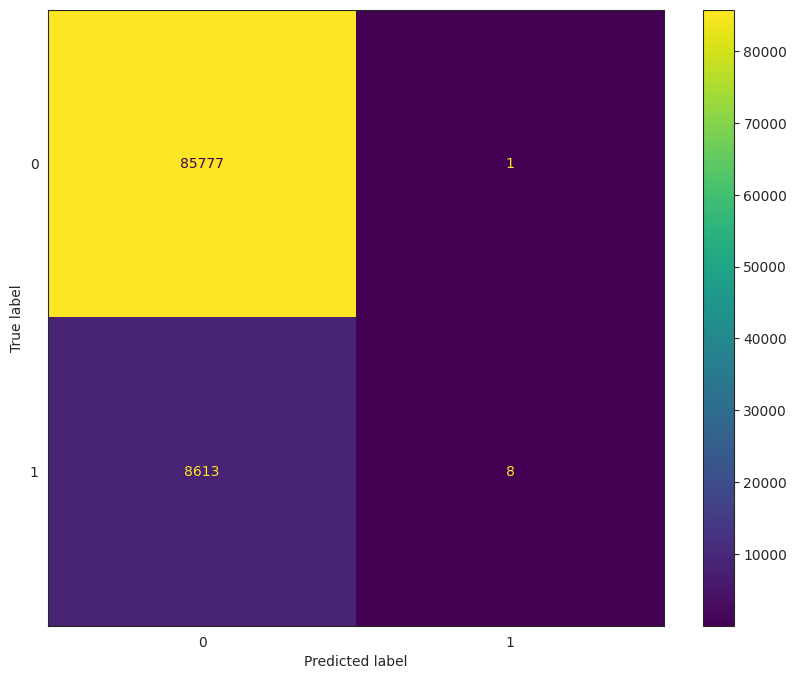

In [102]:
plot_confusion_matrix_custom(y_test, y_pred_gbc_1, gbc_1.classes_, title = 'Confusion Matrix for GradientBoostingClassifier')

In [103]:
print(classification_report(y_test, y_pred_gbc_1))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     85778
           1       0.89      0.00      0.00      8621

    accuracy                           0.91     94399
   macro avg       0.90      0.50      0.48     94399
weighted avg       0.91      0.91      0.87     94399



## **Random Forest Classifier**

In [104]:
# Random Forest Classifier, Balanced
rf_1 = RandomForestClassifier(random_state=1234)

# Fit pipeline with sample weights
rf_1.fit(X_train, y_train)

# Step 1: Generate Predictions
y_pred_rf_1 = rf_1.predict(X_test)

# Step 2: Evaluate Metrics
metrics_rf_1 = get_metrics(y_test, y_pred_rf_1, 'RandomForestClassifier_wo_std')

# Step 3: View Results
metrics_rf_1

{'Model': 'RandomForestClassifier_wo_std',
 'Accuracy': 0.8920009745865952,
 'Balanced Accuracy': 0.536525119892485,
 'Macro Recall': 0.536525119892485,
 'Macro Precision': 0.5891688824436192,
 'Weighted Recall': 0.8920009745865952,
 'Weighted Precision': 0.8554528093411268,
 'Macro F1': 0.5445001479447867,
 'Weighted F1': 0.8696847557311596,
 'MCC Score': 0.11413858457037367,
 'F2 Score': 0.8825355167457106}

Confusion Matrix for RandomForestClassifier


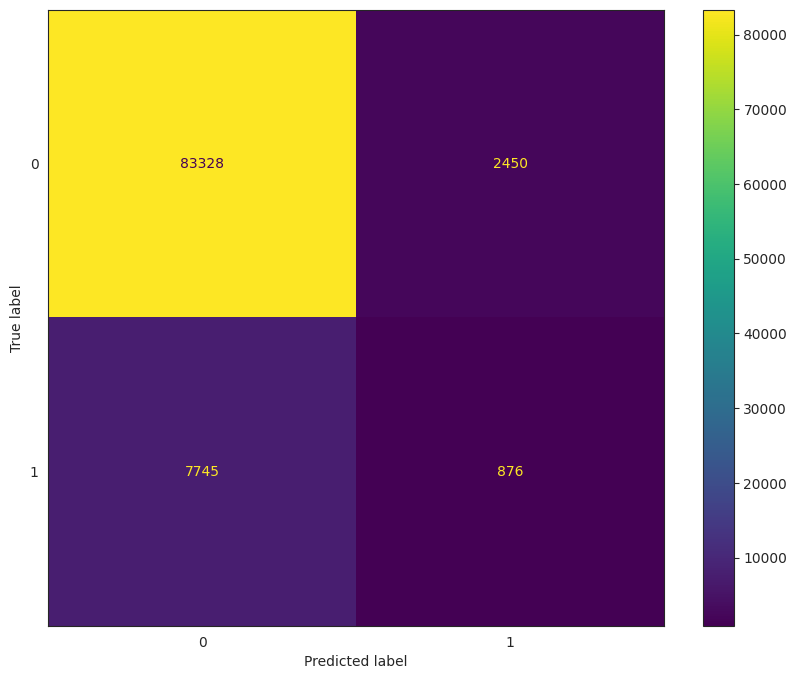

In [105]:
plot_confusion_matrix_custom(y_test, y_pred_rf_1, rf_1.classes_, title = 'Confusion Matrix for RandomForestClassifier')

In [106]:
print(classification_report(y_test, y_pred_rf_1))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94     85778
           1       0.26      0.10      0.15      8621

    accuracy                           0.89     94399
   macro avg       0.59      0.54      0.54     94399
weighted avg       0.86      0.89      0.87     94399



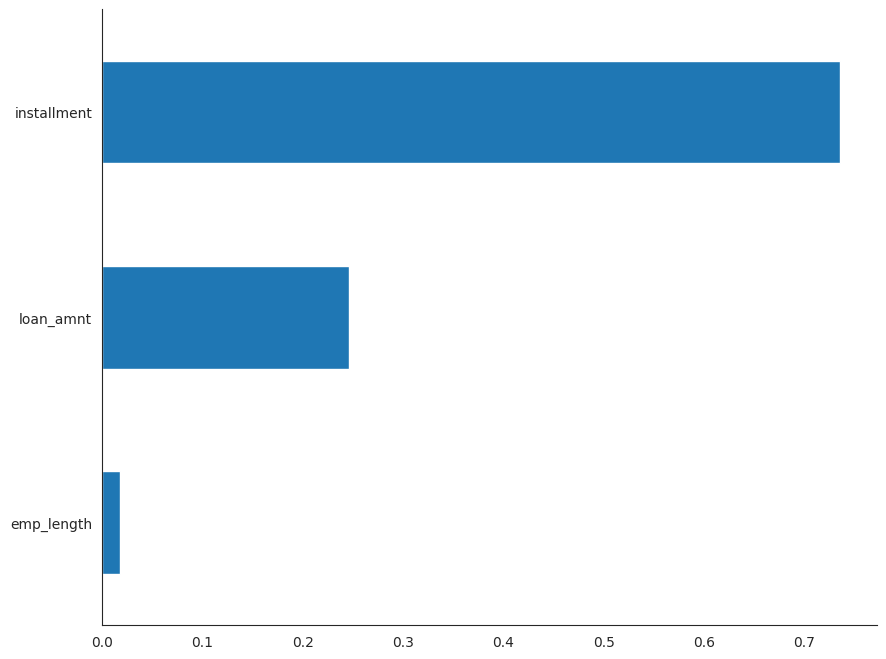

In [107]:
plt.rcParams['figure.figsize']=10,8
sns.set_style("white")
feat_importances = pd.Series(rf_1.feature_importances_, index=rf_1.feature_names_in_)
feat_importances = feat_importances.groupby(level=0).mean()
feat_importances.nlargest(20).plot(kind='barh').invert_yaxis()
sns.despine()
plt.show()

## **Support Vector Classifier**

In [108]:
'''
svc_1 = SVC().fit(X_train_std,y_train)
y_pred_svc_1 = svc_1.predict(X_test_std)
metrics_svc_1 = get_metrics(y_test, y_pred_svc_1, 'SVClassifier_w_std')
metrics_svc_1
plot_confusion_matrix_custom(y_test, y_pred_svc_1, svc_1.classes_, title = 'Confusion Matrix for Support Vector Classifier')
print(classification_report(y_test, y_pred_svc_1))
'''

"\nsvc_1 = SVC().fit(X_train_std,y_train)\ny_pred_svc_1 = svc_1.predict(X_test_std)\nmetrics_svc_1 = get_metrics(y_test, y_pred_svc_1, 'SVClassifier_w_std')\nmetrics_svc_1\nplot_confusion_matrix_custom(y_test, y_pred_svc_1, svc_1.classes_, title = 'Confusion Matrix for Support Vector Classifier')\nprint(classification_report(y_test, y_pred_svc_1))\n"

## **XGBoost Classifier**

In [109]:
xgbc_1 = xgb.XGBClassifier()
xgbc_1.fit(X_train, y_train)
y_pred_xgbc_1 = xgbc_1.predict(X_test)
metrics_xgbc_1 = get_metrics(y_test, y_pred_xgbc_1, 'XGBClassifier_wo_std')
metrics_xgbc_1

{'Model': 'XGBClassifier_wo_std',
 'Accuracy': 0.9086536933653958,
 'Balanced Accuracy': 0.5028576321388828,
 'Macro Recall': 0.5028576321388828,
 'Macro Precision': 0.7001105761436587,
 'Weighted Recall': 0.9086536933653958,
 'Weighted Precision': 0.8709686732551806,
 'Macro F1': 0.4823538190175221,
 'Weighted F1': 0.8663103409172126,
 'MCC Score': 0.04782645350508377,
 'F2 Score': 0.8911317120113876}

Confusion Matrix for XGB Classifier without Standardization


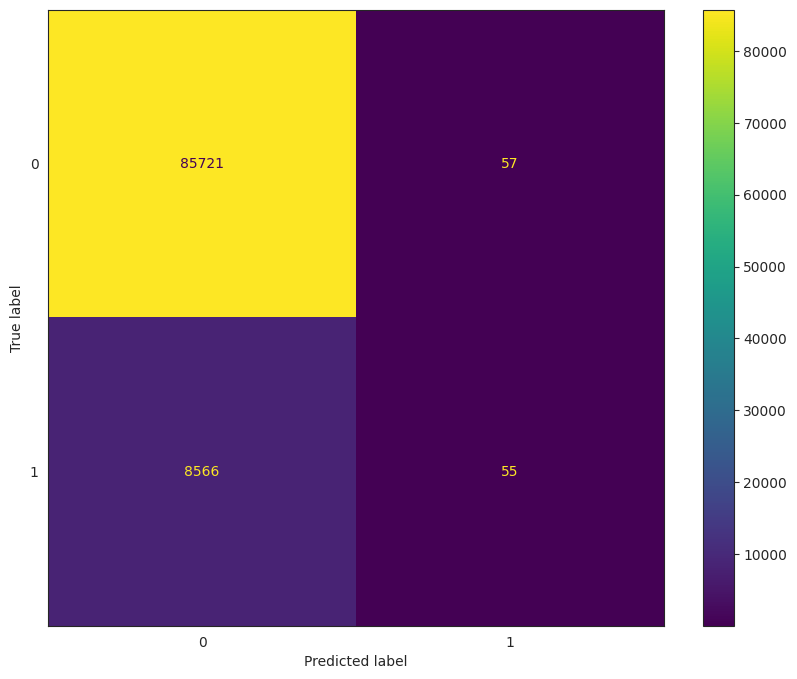

In [110]:
plot_confusion_matrix_custom(y_test, y_pred_xgbc_1, xgbc_1.classes_, title = 'Confusion Matrix for XGB Classifier without Standardization')

In [111]:
print(classification_report(y_test, y_pred_xgbc_1))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     85778
           1       0.49      0.01      0.01      8621

    accuracy                           0.91     94399
   macro avg       0.70      0.50      0.48     94399
weighted avg       0.87      0.91      0.87     94399



## **LightGBM Classifier**

In [112]:
lgbc_1 = lgb.LGBMClassifier()
lgbc_1.fit(X_train, y_train)
y_pred_lgbc_1 = lgbc_1.predict(X_test)
metrics_lgbc_1 = get_metrics(y_test, y_pred_lgbc_1, 'LGBClassifier_wo_std')
metrics_lgbc_1

[LightGBM] [Info] Number of positive: 34484, number of negative: 343109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 377593, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091326 -> initscore=-2.297553
[LightGBM] [Info] Start training from score -2.297553


{'Model': 'LGBClassifier_wo_std',
 'Accuracy': 0.9087278466932912,
 'Balanced Accuracy': 0.5007073408534332,
 'Macro Recall': 0.5007073408534332,
 'Macro Precision': 0.7639199611693201,
 'Weighted Recall': 0.9087278466932912,
 'Weighted Precision': 0.8823313352419703,
 'Macro F1': 0.47759167234420136,
 'Weighted F1': 0.8654920630324571,
 'MCC Score': 0.027326278237004165,
 'F2 Score': 0.8909014759627202}

Confusion Matrix for LGB Classifier without Standardization


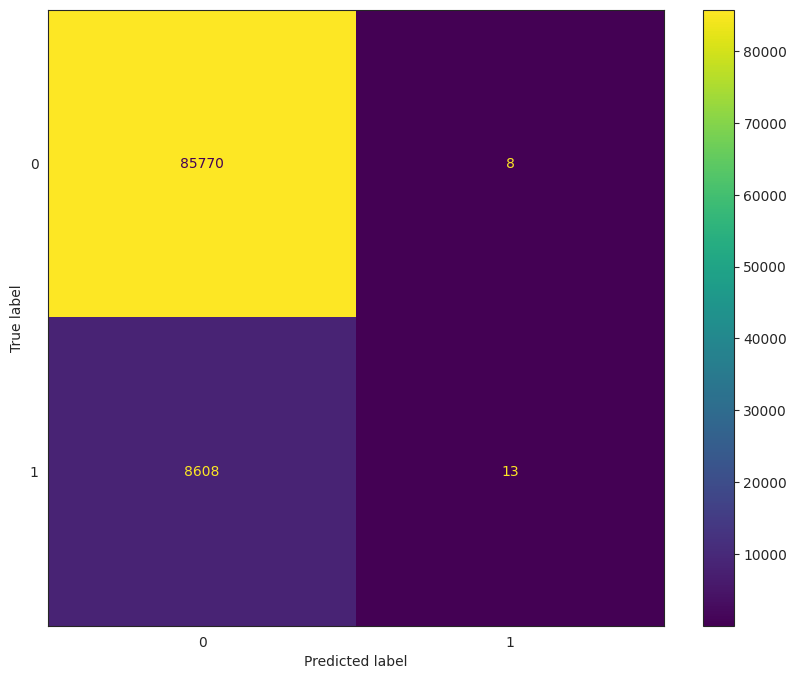

In [113]:
plot_confusion_matrix_custom(y_test, y_pred_lgbc_1, lgbc_1.classes_, title = 'Confusion Matrix for LGB Classifier without Standardization')

In [114]:
print(classification_report(y_test, y_pred_lgbc_1))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     85778
           1       0.62      0.00      0.00      8621

    accuracy                           0.91     94399
   macro avg       0.76      0.50      0.48     94399
weighted avg       0.88      0.91      0.87     94399



## **MLP Classifier**

In [115]:
mlpc_1 = MLPClassifier(hidden_layer_sizes = (5,5,5),
                      activation='relu',
                      solver='adam',
                      batch_size=32,
                      verbose=0).fit(X_train,y_train)
y_pred_mlpc_1 = mlpc_1.predict(X_test)
metrics_mlpc_1 = get_metrics(y_test, y_pred_mlpc_1, 'MLPClassifier_wo_std')
metrics_mlpc_1

{'Model': 'MLPClassifier_wo_std',
 'Accuracy': 0.9086748800305088,
 'Balanced Accuracy': 0.5,
 'Macro Recall': 0.5,
 'Macro Precision': 0.4543374400152544,
 'Weighted Recall': 0.9086748800305088,
 'Weighted Precision': 0.8256900375984596,
 'Macro F1': 0.47607630274674345,
 'Weighted F1': 0.8651971545675305,
 'MCC Score': 0.0,
 'F2 Score': 0.8907697618946379}

Confusion Matrix for MLP Classifier


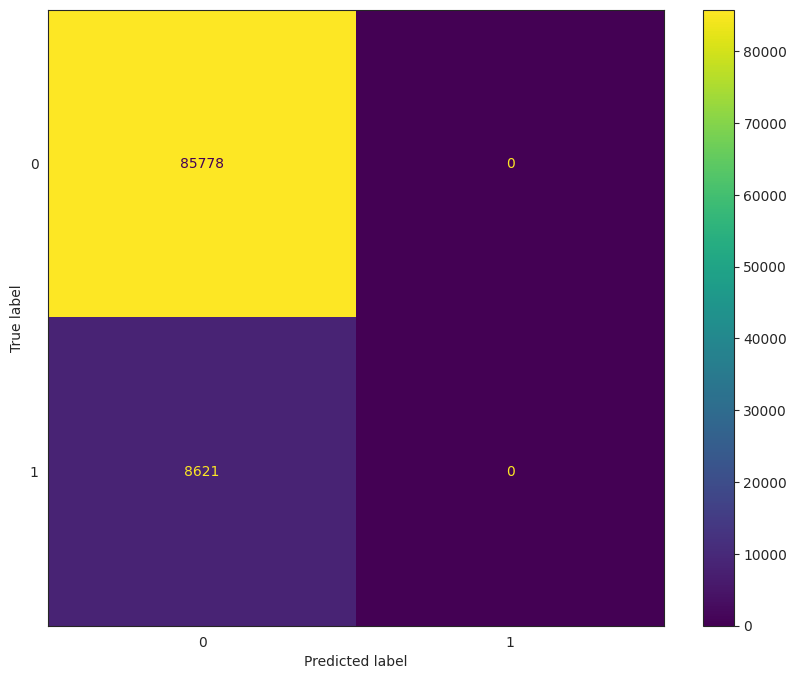

In [116]:
plot_confusion_matrix_custom(y_test, y_pred_mlpc_1, mlpc_1.classes_, title = 'Confusion Matrix for MLP Classifier')

In [117]:
print(classification_report(y_test, y_pred_mlpc_1))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     85778
           1       0.00      0.00      0.00      8621

    accuracy                           0.91     94399
   macro avg       0.45      0.50      0.48     94399
weighted avg       0.83      0.91      0.87     94399



# **Model comparison iteration**

In [118]:
pd.DataFrame({'metrics_lr_1':pd.Series(metrics_lr_1),
              'metrics_knn_1':pd.Series(metrics_knn_1),
              'metrics_gbc_1':pd.Series(metrics_gbc_1),
              'metrics_dt_1':pd.Series(metrics_dt_1),
              'metrics_dt_2':pd.Series(metrics_dt_2),
              'metrics_xgbc_1':pd.Series(metrics_xgbc_1),
              'metrics_lgbc_1':pd.Series(metrics_lgbc_1),
              'metrics_rf_1':pd.Series(metrics_rf_1),
              'metrics_mlpc_1':pd.Series(metrics_mlpc_1)
             }
            ).iloc[1:,:].T

,Accuracy,Balanced Accuracy,Macro Recall,Macro Precision,Weighted Recall,Weighted Precision,Macro F1,Weighted F1,MCC Score,F2 Score
metrics_lr_1,0.908675,0.5,0.5,0.454337,0.908675,0.82569,0.476076,0.865197,0.0,0.89077
metrics_knn_1,0.898823,0.521811,0.521811,0.588405,0.898823,0.853199,0.52247,0.868972,0.087823,0.886198
metrics_gbc_1,0.908749,0.500458,0.500458,0.89882,0.908749,0.906937,0.477022,0.8654,0.027035,0.890884
metrics_dt_1,0.879755,0.551646,0.551646,0.58059,0.879755,0.856174,0.560434,0.866654,0.129029,0.874278
metrics_dt_2,0.786322,0.578539,0.578539,0.543855,0.786322,0.855059,0.546667,0.816075,0.117377,0.796772
metrics_xgbc_1,0.908654,0.502858,0.502858,0.700111,0.908654,0.870969,0.482354,0.86631,0.047826,0.891132
metrics_lgbc_1,0.908728,0.500707,0.500707,0.76392,0.908728,0.882331,0.477592,0.865492,0.027326,0.890901
metrics_rf_1,0.892001,0.536525,0.536525,0.589169,0.892001,0.855453,0.5445,0.869685,0.114139,0.882536
metrics_mlpc_1,0.908675,0.5,0.5,0.454337,0.908675,0.82569,0.476076,0.865197,0.0,0.89077
